# A benchmark model of dynamic portfolio choice with transaction costs

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import gpytorch
from scipy.optimize import minimize
from torch.optim import Adam
from gpytorch.models import ExactGP
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, MaternKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from cyipopt import minimize_ipopt


%matplotlib inline
%load_ext autoreload
%autoreload 2


Current issues: Gradient of Ct is NaN. Check with pdf

# Current implementation

In [3]:
import torch
import torch.autograd as autograd
import gpytorch
from gpytorch.models import ExactGP
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, MaternKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from cyipopt import minimize_ipopt
import numpy as np

# Parameters
T = 10  # Time horizon
D = 2  # Number of risky assets
r = 0.03  # Risk-free return in pct.
Rf = np.exp(r)  # Risk-free return
tau = 0.01  # Transaction cost rate
beta = 0.975  # Discount factor
gamma = 3.5  # Risk aversion coefficient

# Risky assets - deterministic
mu = np.array([0.07, 0.07])
variance = 0.2**2
Sigma = np.array([[0.04, 0], [0, 0.04]])

# Define the GPR model with ARD
class GPRegressionModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean()
        self.covar_module = ScaleKernel(MaternKernel(nu=1.5, ard_num_dims=train_x.shape[1]))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Function to train the GPR model
def train_gp_model(train_x, train_y):
    likelihood = GaussianLikelihood()
    model = GPRegressionModel(train_x, train_y, likelihood)
    model.train()
    likelihood.train()

    # Use the Adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

    # "Loss" for GPs - the marginal log likelihood
    mll = ExactMarginalLogLikelihood(likelihood, model)

    training_iterations = 40
    for i in range(training_iterations):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()

    print(f"Trained model on inputs: {train_x}")
    print(f"Trained model on targets: {train_y}")        
    
    return model, likelihood
# Utility function
def utility(ct, gamma):
    if gamma == 1:
        return torch.log(ct)
    else:
        return (ct**(1 - gamma)) / (1 - gamma)

def safe_utility(ct, gamma):
    ct = torch.tensor(ct, dtype=torch.float32)  # Ensure ct is a tensor
    ct = torch.clamp(ct, min=1e-6)  # Prevent log(0) or negative values
    return utility(ct, gamma)

# Normalized bond holdings
def normalized_bond_holdings(xt, delta_plus, delta_minus, ct, tau):
    bt = 1 - torch.sum(xt - delta_plus + delta_minus + tau * (delta_plus + delta_minus)) - ct
    return bt

def normalized_state_dynamics(xt, delta_plus, delta_minus, Rt, bt, Rf):
    pi_t1 = bt * Rf + torch.sum((xt + delta_plus - delta_minus) * Rt)
    xt1 = ((xt + delta_plus - delta_minus) * Rt) / pi_t1
    return pi_t1, xt1

def bellman_equation(vt_next_in, vt_next_out, xt, ct, delta_plus, delta_minus, beta, gamma, tau, Rf):
    bt = normalized_bond_holdings(torch.tensor(xt, requires_grad=True), torch.tensor(delta_plus, requires_grad=True), torch.tensor(delta_minus, requires_grad=True), torch.tensor(ct, requires_grad=True), tau)
    Rt = torch.tensor(mu + np.random.multivariate_normal(np.zeros(D), Sigma))  # Simulated return
    pi_t1, xt1 = normalized_state_dynamics(xt, delta_plus, delta_minus, Rt, bt, Rf)
    
    u = safe_utility(ct, gamma)
    xt1_tensor = torch.tensor(xt1, dtype=torch.float32, requires_grad=True)
    
    if vt_next_in is None or vt_next_out is None:
        raise ValueError("vt_next_in or vt_next_out is None")
    
    if is_in_ntr(xt1):
        vt_next_val = vt_next_in(xt1_tensor.unsqueeze(0)).mean()
    else:
        vt_next_val = vt_next_out(xt1_tensor.unsqueeze(0)).mean()
    
    vt = u + beta * torch.mean(pi_t1 ** (1 - gamma) * vt_next_val)
    
    return vt

def solve_optimization(xt, vt_next_in, vt_next_out):
    def objective(params):
        delta_plus = torch.tensor(params[:D], dtype=torch.float32, requires_grad=True)
        delta_minus = torch.tensor(params[D:2*D], dtype=torch.float32, requires_grad=True)
        ct = torch.tensor(params[2*D], dtype=torch.float32, requires_grad=True)
        vt = bellman_equation(vt_next_in, vt_next_out, xt, ct, delta_plus, delta_minus, beta, gamma, tau, Rf)
        return vt

    def gradient(params):
        delta_plus = torch.tensor(params[:D], dtype=torch.float32, requires_grad=True)
        delta_minus = torch.tensor(params[D:2*D], dtype=torch.float32, requires_grad=True)
        ct = torch.tensor(params[2*D], dtype=torch.float32, requires_grad=True)
        vt = bellman_equation(vt_next_in, vt_next_out, xt, ct, delta_plus, delta_minus, beta, gamma, tau, Rf)
        vt.backward()
        
        grad = np.concatenate([
            delta_plus.grad.detach().numpy(),
            delta_minus.grad.detach().numpy(),
            [ct.grad.detach().numpy()]
        ])
        
        return grad

    def constraints(params):
        delta_plus = torch.tensor(params[:D], dtype=torch.float32, requires_grad=True)
        delta_minus = torch.tensor(params[D:2*D], dtype=torch.float32, requires_grad=True)
        ct = torch.tensor(params[2*D], dtype=torch.float32, requires_grad=True)
        no_shorting_plus = delta_plus  # No shorting constraint
        no_shorting_minus = delta_minus  # No shorting constraint
        no_borrowing = normalized_bond_holdings(xt, delta_plus, delta_minus, ct, tau).detach()  # No borrowing constraint
        return torch.cat([no_shorting_plus, no_shorting_minus, torch.tensor([no_borrowing])]).detach().numpy()

    def jacobian(params):
        delta_plus = torch.tensor(params[:D], dtype=torch.float32, requires_grad=True)
        delta_minus = torch.tensor(params[D:2*D], dtype=torch.float32, requires_grad=True)
        ct = torch.tensor(params[2*D], dtype=torch.float32, requires_grad=True)
        bt = normalized_bond_holdings(xt, delta_plus, delta_minus, ct, tau)
        grads = autograd.grad(bt, [delta_plus, delta_minus, ct], create_graph=True)
        jac = np.concatenate([g.detach().numpy().flatten() for g in grads])
        return jac

    initial_guesses = [np.zeros(2*D + 1) for _ in range(5)]

    bounds = [(0, 1)] * D + [(-1, 0)] * D  # Correct bounds

    constraints_def = [{'type': 'ineq', 'fun': lambda x: constraints(x)}]
    tol = 1e-6

    for initial_guess in initial_guesses:
        result = minimize_ipopt(objective, initial_guess, bounds=bounds, constraints=constraints_def, jac=gradient, options={'tol': tol, 'maxiter': 300})
        if result.success:
            break
    
    delta_plus = result.x[:D]
    delta_minus = result.x[D:2*D]
    ct = result.x[2*D]
    return delta_plus, delta_minus, ct


def dynamic_programming(T, N, D, gamma, beta, tau, Rf):
    V = initialize_value_function(T, gamma)
    
    for t in range(T-1, -1, -1):
        Xt = sample_state_points(D)
        
        vt_values_in = []
        vt_values_out = []
        policies_in = []
        policies_out = []
        
        for xt in Xt:
            print(f"Time step {t}, state {xt}")
            if V[t+1][0] is None or V[t+1][1] is None:
                print(f"V[t+1][0] or V[t+1][1] is None at time {t+1}")
            
            delta_plus, delta_minus, ct = solve_optimization(xt, V[t+1][0], V[t+1][1])
            vt_value = bellman_equation(V[t+1][0], V[t+1][1], xt, ct, delta_plus, delta_minus, beta, gamma, tau, Rf).item()
            
            if is_in_ntr(xt):
                vt_values_in.append(vt_value)
                policies_in.append((xt, delta_plus, delta_minus, ct))
                # Placeholder!
                vt_values_out.append(vt_value)
                policies_out.append((xt, delta_plus, delta_minus, ct))
            else:
                vt_values_out.append(vt_value)
                policies_out.append((xt, delta_plus, delta_minus, ct))
        
        Xt_tensor_in = torch.tensor([x[0].numpy() for x in policies_in], dtype=torch.float32)
        vt_values_tensor_in = torch.tensor(vt_values_in, dtype=torch.float32)
        
        V[t][0], _ = train_gp_model(Xt_tensor_in, vt_values_tensor_in)

        Xt_tensor_out = torch.tensor([x[0].numpy() for x in policies_out], dtype=torch.float32)
        vt_values_tensor_out = torch.tensor(vt_values_out, dtype=torch.float32)
        
        V[t][1], _ = train_gp_model(Xt_tensor_out, vt_values_tensor_out)
    
    return V  

def is_in_ntr(xt):
    # Placeholder for logic to determine if a point is inside the NTR
    # This will use the approximation method described in the PDFs
    return True  # Change this based on actual logic

def initialize_value_function(T, gamma):
    V = [[None, None] for _ in range(T + 1)]
    def V_terminal(xT):
        return utility(1 - tau * torch.sum(torch.abs(xT)), gamma)
    V[T][0] = V[T][1] = lambda x: V_terminal(x)
    return V

# Sample state points function
def sample_state_points(D):
    points = []
    for i in range(2 ** D):
        point = [(i >> j) & 1 for j in range(D)]
        points.append(point)
    points.append([0] * D)
    for i in range(1, 2 ** D):
        for j in range(i):
            midpoint = [(a + b) / 2 for a, b in zip(points[i], points[j])]
            points.append(midpoint)
    return torch.tensor(points, dtype=torch.float32)

# Define parameters and run the algorithm
N = 50  # Number of sample points
V = dynamic_programming(T, N, D, gamma, beta, tau, Rf)

# V now contains the approximated value functions for each time period

Time step 9, state tensor([0., 0.])


ValueError: The number of lower bounds, upper bounds, and decision variables must be equal or broadcastable.

# Consumption only in the final period


In [4]:
import torch
import torch.autograd as autograd
import gpytorch
from gpytorch.models import ExactGP
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, MaternKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from cyipopt import minimize_ipopt
import numpy as np

np.random.seed(2001)

# Parameters
T = 10  # Time horizon
D = 2  # Number of risky assets
r = 0.03  # Risk-free return in pct.
Rf = np.exp(r)  # Risk-free return
tau = 0.01  # Transaction cost rate
beta = 0.975  # Discount factor
gamma = 3.5  # Risk aversion coefficient

# Risky assets - deterministic
mu = np.array([0.07, 0.07])
variance = 0.2**2
Sigma = np.array([[0.00, 0], [0, 0.00]])

# Define the GPR model with ARD
class GPRegressionModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean()
        self.covar_module = ScaleKernel(MaternKernel(nu=1.5, ard_num_dims=train_x.shape[1]))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

def train_gp_model(train_x, train_y):
    likelihood = GaussianLikelihood()
    model = GPRegressionModel(train_x, train_y, likelihood)
    model.train()
    likelihood.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    mll = ExactMarginalLogLikelihood(likelihood, model)

    training_iterations = 100
    for i in range(training_iterations):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()

    print(f"Trained model on inputs: {train_x}")
    print(f"Trained model on targets: {train_y}")        
    
    return model, likelihood

def utility(ct, gamma):
    if gamma == 1:
        return torch.log(ct)
    else:
        return (ct**(1 - gamma)) / (1 - gamma)
#Utility function but no log(0)
def safe_utility(ct, gamma):
    ct = torch.tensor(ct, dtype=torch.float32)  # Ensure ct is a tensor
    ct = torch.clamp(ct, min=1e-6)  # Prevent log(0) or negative values
    return utility(ct, gamma)


# Utility function for wealth (instead of consumption)
def utility_wealth(pi_t1, gamma):
    if gamma == 1:
        return torch.log(pi_t1)
    else:
        return (pi_t1**(1 - gamma)) / (1 - gamma)
def safe_utility(pi_t1, gamma):
    pi_t1 = torch.tensor(pi_t1, dtype=torch.float32)  # Ensure ct is a tensor
    pi_t1 = torch.clamp(pi_t1, min=1e-5)  # Prevent log(0) or negative values
    return utility_wealth(pi_t1, gamma)


# Normalized bond holdings
def normalized_bond_holdings(xt, delta_plus, delta_minus, tau):
    bt = 1 - torch.sum(xt - delta_plus + delta_minus + tau * (delta_plus + delta_minus))
    bt = torch.clamp(bt, min=0)  # Ensure no negative bond holdings
    return bt

def normalized_state_dynamics(xt, delta_plus, delta_minus, Rt, bt, Rf):
    pi_t1 = bt * Rf + torch.sum((xt + delta_plus - delta_minus) * Rt)
    pi_t1 = torch.clamp(pi_t1, min=1e-6)  # Avoid division by zero or negative wealth
    xt1 = ((xt + delta_plus - delta_minus) * Rt) / pi_t1
    return pi_t1, xt1

def bellman_equation(vt_next_in, vt_next_out, xt, delta_plus, delta_minus, beta, gamma, tau, Rf, t, T):
    # Compute bond holdings
    bt = normalized_bond_holdings(torch.tensor(xt, requires_grad=True), torch.tensor(delta_plus, requires_grad=True), torch.tensor(delta_minus, requires_grad=True), tau)

    # Simulate returns for risky assets
    # Rt = torch.tensor(mu + np.random.multivariate_normal(np.zeros(D), Sigma))  # Simulated return
    Rt = torch.tensor(mu,dtype=torch.float32)  # Simulated return

    # Compute next period wealth dynamics
    pi_t1, xt1 = normalized_state_dynamics(xt, delta_plus, delta_minus, Rt, bt, Rf)
    if torch.isnan(pi_t1) or torch.isnan(xt1).any():
        print(f"NaN detected in state dynamics at time {t}.")
        return torch.tensor(float('nan'))
    # Compute utility from wealth
    u = safe_utility(pi_t1, gamma)

    # Convert next state to a tensor
    xt1_tensor = torch.tensor(xt1, dtype=torch.float32, requires_grad=True)

    # Determine whether the next state is inside or outside the NTR, and select the corresponding GPR
    if is_in_ntr(xt1_tensor):
        # Check if vt_next_in is a GP model or a function
        if isinstance(vt_next_in, gpytorch.models.ExactGP):
            vt_next_in.eval()  # Set the GP model to evaluation mode
            vt_next_val = vt_next_in(xt1_tensor.unsqueeze(0)).mean()
        elif callable(vt_next_in):  # If it's a function like V_terminal
            vt_next_val = vt_next_in(xt1_tensor)
        else:
            raise TypeError("Expected vt_next_in to be a GP model or function.")
    else:
        # Check if vt_next_out is a GP model or a function
        if isinstance(vt_next_out, gpytorch.models.ExactGP):
            vt_next_out.eval()  # Set the GP model to evaluation mode
            vt_next_val = vt_next_out(xt1_tensor.unsqueeze(0)).mean()
        elif callable(vt_next_out):  # If it's a function like V_terminal
            vt_next_val = vt_next_out(xt1_tensor)
        else:
            raise TypeError("Expected vt_next_out to be a GP model or function.")

    # Check for NaN in vt_next_val
    if torch.isnan(vt_next_val):
        print(f"NaN detected in value function at time {t}.")
        return torch.tensor(float('nan'))

    # Bellman equation
    vt = u + beta * torch.mean(pi_t1 ** (1 - gamma) * vt_next_val)

    # Check for NaN in the final value
    if torch.isnan(vt):
        print(f"NaN detected in final Bellman value at time {t}.")
        return torch.tensor(float('nan'))

    # Bellman equation
    vt = u + beta * torch.mean(pi_t1 ** (1 - gamma) * vt_next_val)
    
    return vt

def solve_optimization(xt, vt_next_in, vt_next_out, t, T):
    # Define the number of decision variables (2D for portfolio choices + 1 for consumption only in final period)
    # num_params = 2 * D + (1 if t == T else 0)
    num_params = 2 * D

    def objective(params):
        delta_plus = torch.tensor(params[:D], dtype=torch.float32, requires_grad=True)
        delta_minus = torch.tensor(params[D:2*D], dtype=torch.float32, requires_grad=True)
        
        vt = bellman_equation(vt_next_in, vt_next_out, xt, delta_plus, delta_minus, beta, gamma, tau, Rf, t, T)
        return vt


    def gradient(params):
        delta_plus = torch.tensor(params[:D], dtype=torch.float32, requires_grad=True)
        delta_minus = torch.tensor(params[D:2*D], dtype=torch.float32, requires_grad=True)

        # Compute the value using the Bellman equation
        vt = bellman_equation(vt_next_in, vt_next_out, xt, delta_plus, delta_minus, beta, gamma, tau, Rf, t, T)
        
        # Backpropagate the gradients
        vt.backward()

        grad = np.concatenate([
            delta_plus.grad.detach().numpy(),
            delta_minus.grad.detach().numpy()
        ])
        
        return grad

    def constraints(params):
        delta_plus = torch.tensor(params[:D], dtype=torch.float32, requires_grad=True)
        delta_minus = torch.tensor(params[D:2*D], dtype=torch.float32, requires_grad=True)

        # Compute bond holdings and constraints
        no_borrowing = normalized_bond_holdings(xt, delta_plus, delta_minus, tau).detach()
        
        return torch.cat([delta_plus, delta_minus, torch.tensor([no_borrowing])]).detach().numpy()

    initial_guesses = [np.zeros(num_params) for _ in range(5)]
    bounds = [(-1e-16, 1)] * num_params  # Ensure valid parameters
    # Adjust bounds for delta_plus [0,1] and delta_minus [-1,0]
    bounds = [(0, 1)] * D + [(-1, 0)] * D  # Correct bounds
    
    constraints_def = [{'type': 'ineq', 'fun': lambda x: constraints(x)}]

    for initial_guess in initial_guesses:
        result = minimize_ipopt(objective, initial_guess, bounds=bounds, constraints=constraints_def, jac=gradient, options={'tol': 1e-6, 'maxiter': 300})
        if result.success:
            break

    delta_plus = result.x[:D]
    delta_minus = result.x[D:2*D]

    # Check for invalid values and log
    if np.isnan(delta_plus).any() or np.isnan(delta_minus).any():
        print(f"Invalid optimization results at time {t}:")
        print(f"xt = {xt}, delta_plus = {delta_plus}, delta_minus = {delta_minus}")
        print(f"Initial guess: {initial_guess}")
        print(f"Result: {result}")

    return delta_plus, delta_minus

def dynamic_programming(T, N, D, gamma, beta, tau, Rf):
    V = initialize_value_function(T, gamma)
    
    def V_terminal(xT):
        return utility(1 - tau * torch.sum(torch.abs(xT)), gamma)

    # Outer loop over time steps: This is part of Algorithm 1
    for t in range(T-1, -1, -1):
        Xt = sample_state_points(D)  # Sample state points for time step t

        vt_values_in = []
        vt_values_out = []
        policies_in = []
        policies_out = []

        # Loop over sampled state points Xt: This is part of Algorithm 1
        for xt in Xt:
            print(f"Time step {t}, state {xt}")
            if V[t+1][0] is None or V[t+1][1] is None:
                print(f"V[t+1][0] or V[t+1][1] is None at time {t+1}")
            
            # Solve optimization to find policy (delta_plus, delta_minus)
            # This corresponds to step 1.3 of Algorithm 1

            # Ensure V[t+1][0] and V[t+1][1] are functions or GP models before passing them
            if not callable(V[t+1][0]) and not isinstance(V[t+1][0], gpytorch.models.ExactGP):
                V[t+1][0] = V_terminal

            if not callable(V[t+1][1]) and not isinstance(V[t+1][1], gpytorch.models.ExactGP):
                V[t+1][1] = V_terminal

            delta_plus, delta_minus = solve_optimization(xt, V[t+1][0], V[t+1][1], t, T)

            # Compute value function using Bellman equation
            # This corresponds to step 1.4 of Algorithm 1
            vt_value = bellman_equation(V[t+1][0], V[t+1][1], xt,  delta_plus, delta_minus, beta, gamma, tau, Rf, t, T).item()
            
            # Determine if xt is inside or outside the NTR, and store values accordingly
            # This is the branching between Algorithm 1 and 2, step 1.5 of Algorithm 1
            if is_in_ntr(xt):
                # Inside NTR: Algorithm 2 will train GPR for inside region
                vt_values_in.append(vt_value)
                policies_in.append((xt, delta_plus, delta_minus))
            else:
                # Outside NTR: Algorithm 2 will train GPR for outside region
                vt_values_out.append(vt_value)
                policies_out.append((xt, delta_plus, delta_minus))

        # Now we switch to Algorithm 2: Train two separate GPRs (inside and outside NTR)

        # 2.1: Convert policies and values for inside NTR to tensors and train GPR
        Xt_tensor_in = torch.tensor([x[0].numpy() for x in policies_in], dtype=torch.float32)
        vt_values_tensor_in = torch.tensor(vt_values_in, dtype=torch.float32)

        if len(Xt_tensor_in) > 0:
            # Train GPR for inside the NTR: step 2.2 of Algorithm 2
            V[t][0], _ = train_gp_model(Xt_tensor_in, vt_values_tensor_in)
        else:
            # No valid data to train, assign terminal function
            V[t][0] = V_terminal

        # 2.3: Convert policies and values for outside NTR to tensors and train GPR
        Xt_tensor_out = torch.tensor([x[0].numpy() for x in policies_out], dtype=torch.float32)
        vt_values_tensor_out = torch.tensor(vt_values_out, dtype=torch.float32)

        if len(Xt_tensor_out) > 0:
            # Train GPR for outside the NTR: step 2.4 of Algorithm 2
            V[t][1], _ = train_gp_model(Xt_tensor_out, vt_values_tensor_out)
        else:
            # No valid data to train, assign terminal function
            V[t][1] = V_terminal
    return V

def is_in_ntr(xt):
    # Approximate the NTR by sampling the vertices of the simplex.
    # This is a placeholder for a more complex approximation.
    # We could, for example, check if the point is within a convex hull.
    
    # In 2D, let's define a simple parallelogram NTR approximation.
    # You can extend this logic to higher dimensions.
    lower_bounds = torch.zeros_like(xt)
    upper_bounds = torch.ones_like(xt) * .5  # Assume a simple NTR for illustration
    
    return torch.all(xt >= lower_bounds) and torch.all(xt <= upper_bounds)


def initialize_value_function(T, gamma):
    V = [[None, None] for _ in range(T + 1)]

    def V_terminal(xT):
        return safe_utility(1 - tau * torch.sum(torch.abs(xT)), gamma)

    # Set both vt_next_in and vt_next_out to be this function at terminal time
    V[T][0] = V_terminal
    V[T][1] = V_terminal

    return V

def filter_invalid_data(inputs, targets):
    valid_mask = ~torch.isnan(targets) & (torch.abs(targets) < 1e10)
    return inputs[valid_mask], targets[valid_mask]


# Sample state points function
def sample_state_points(D):
    points = []
    # Add corners of the simplex (ends)
    for i in range(2 ** D):
        point = [(i >> j) & 1 for j in range(D)]
        points.append(point)
    points.append([0] * D)
    # Add midpoints between all pairs of points
    for i in range(1, 2 ** D):
        for j in range(i):
            midpoint = [(a + b) / 2 for a, b in zip(points[i], points[j])]
            points.append(midpoint)
    # Add more midpoints by sampling regions with higher uncertainty (optional)
    points = [point for point in points if sum(point) <= 1]
    
    # Remove duplicates
    unique_points = []
    for point in points:
        if point not in unique_points:
            unique_points.append(point)
    
    return torch.tensor(unique_points, dtype=torch.float32)


# Define parameters and run the algorithm
N = 35  # Number of sample points
V = dynamic_programming(T, N, D, gamma, beta, tau, Rf)

# V now contains the approximated value functions for each time period

Time step 9, state tensor([0., 0.])

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



/var/folders/hz/t94d7ym95fx1sf3fpl6b9bcm0000gn/T/ipykernel_22685/1143647688.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bt = normalized_bond_holdings(torch.tensor(xt, requires_grad=True), torch.tensor(delta_plus, requires_grad=True), torch.tensor(delta_minus, requires_grad=True), tau)
/var/folders/hz/t94d7ym95fx1sf3fpl6b9bcm0000gn/T/ipykernel_22685/1143647688.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pi_t1 = torch.tensor(pi_t1, dtype=torch.float32)  # Ensure ct is a tensor
/var/folders/hz/t94d7ym95fx1sf3fpl6b9bcm0000gn/T/ipykernel_22685/1143647688.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTen

Time step 9, state tensor([1., 0.])
Time step 9, state tensor([0., 1.])
Time step 9, state tensor([0.5000, 0.0000])
Time step 9, state tensor([0.0000, 0.5000])
Time step 9, state tensor([0.5000, 0.5000])


/var/folders/hz/t94d7ym95fx1sf3fpl6b9bcm0000gn/T/ipykernel_22685/1143647688.py:269: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/miniforge3/conda-bld/libtorch_1724557170823/work/torch/csrc/utils/tensor_new.cpp:281.)
  Xt_tensor_in = torch.tensor([x[0].numpy() for x in policies_in], dtype=torch.float32)


Trained model on inputs: tensor([[0.0000, 0.0000],
        [0.5000, 0.0000],
        [0.0000, 0.5000],
        [0.5000, 0.5000]])
Trained model on targets: tensor([-7.3292e-01, -3.5567e+00, -3.5009e+00, -7.4273e+02])
Trained model on inputs: tensor([[1., 0.],
        [0., 1.]])
Trained model on targets: tensor([-290.9331, -609.8878])
Time step 8, state tensor([0., 0.])


/var/folders/hz/t94d7ym95fx1sf3fpl6b9bcm0000gn/T/ipykernel_22685/1143647688.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bt = normalized_bond_holdings(torch.tensor(xt, requires_grad=True), torch.tensor(delta_plus, requires_grad=True), torch.tensor(delta_minus, requires_grad=True), tau)
/var/folders/hz/t94d7ym95fx1sf3fpl6b9bcm0000gn/T/ipykernel_22685/1143647688.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pi_t1 = torch.tensor(pi_t1, dtype=torch.float32)  # Ensure ct is a tensor
/var/folders/hz/t94d7ym95fx1sf3fpl6b9bcm0000gn/T/ipykernel_22685/1143647688.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTen

TypeError: 'Tensor' object is not callable

# No NTR LOGIC

In [34]:
import torch
import torch.autograd as autograd
import gpytorch
from gpytorch.models import ExactGP
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, MaternKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from cyipopt import minimize_ipopt
import numpy as np

np.random.seed(2001)

# Parameters
T = 10  # Time horizon
D = 2  # Number of risky assets
r = 0.025  # Risk-free return in pct.
Rf = np.exp(r)  # Risk-free return
tau = 0.001  # Transaction cost rate
beta = 0.975  # Discount factor
gamma = 3.5  # Risk aversion coefficient

# Risky assets - deterministic
mu = np.array([0.09, 0.09])
variance = 0.2**2
Sigma = np.array([[0.15, 0], [0, 0.15]])

# Define the GPR model with ARD
class GPRegressionModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean()
        self.covar_module = ScaleKernel(MaternKernel(nu=1.5, ard_num_dims=train_x.shape[1]))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

def train_gp_model(train_x, train_y):
    train_y = torch.clamp(train_y, min=-1e16, max=1e16)  # Adjust these limits as necessary

    likelihood = GaussianLikelihood()
    model = GPRegressionModel(train_x, train_y, likelihood)
    model.train()
    likelihood.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    mll = ExactMarginalLogLikelihood(likelihood, model)

    training_iterations = 100
    for i in range(training_iterations):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        # loss.backward()
        loss.backward(retain_graph=True)
        optimizer.step()

    print(f"Trained model on inputs: {train_x}")
    print(f"Trained model on targets: {train_y}")        
    
    return model, likelihood

def utility(ct, gamma):
    if gamma == 1:
        return torch.log(ct)
    else:
        return (ct**(1 - gamma)) / (1 - gamma)

def safe_utility(ct, gamma):
    # Removed unnecessary re-wrapping of the tensor if it already has requires_grad=True
    ct = torch.clamp(ct, min=1e-6)  # Prevent log(0) or negative values
    return utility(ct, gamma)

# Utility function for wealth (instead of consumption)
def utility_wealth(pi_t1, gamma):
    if gamma == 1:
        return torch.log(pi_t1)
    else:
        return (pi_t1**(1 - gamma)) / (1 - gamma)
    
def safe_utility(pi_t1, gamma):
    # Removed unnecessary re-wrapping of the tensor if it already has requires_grad=True
    pi_t1 = torch.clamp(pi_t1, min=1e-5)  # Prevent log(0) or negative values
    return utility_wealth(pi_t1, gamma)

def normalized_bond_holdings(xt, delta_plus, delta_minus, tau):
    # Element-wise operations to compute total transaction costs
    transaction_costs = tau * (torch.abs(delta_plus) + torch.abs(delta_minus))
    
    # Compute the total bond holdings as 1 minus the sum of risky assets and transaction costs
    bt = 1 - torch.sum(xt + delta_plus - delta_minus) - torch.sum(transaction_costs)
    
    # Ensure no negative bond holdings, but DO NOT detach here
    bt = torch.clamp(bt, min=0)
    
    return bt

def normalized_state_dynamics(xt, delta_plus, delta_minus, Rt, bt, Rf):
    pi_t1 = bt * Rf + torch.sum((xt + delta_plus - delta_minus) * Rt)
    pi_t1 = torch.clamp(pi_t1, min=1e-6)  # Avoid division by zero or negative wealth
    xt1 = ((xt + delta_plus - delta_minus) * Rt) / pi_t1
    return pi_t1, xt1

def bellman_equation(vt_next_in, vt_next_out, xt, delta_plus, delta_minus, beta, gamma, tau, Rf, t, T):
    # Compute bond holdings, removed re-wrapping tensors unnecessarily
    bt = normalized_bond_holdings(xt, delta_plus, delta_minus, tau)

    # Simulate returns for risky assets
    # Rt = torch.tensor(mu + np.random.multivariate_normal(np.zeros(D), Sigma), dtype=torch.float32, requires_grad=True)  # Simulated return
    Rt = torch.tensor(mu, dtype=torch.float32, requires_grad=True)  # Simulated return

    # Compute next period wealth dynamics
    pi_t1, xt1 = normalized_state_dynamics(xt, delta_plus, delta_minus, Rt, bt, Rf)

    # Compute utility from wealth
    u = safe_utility(pi_t1, gamma)

    # IN FINAL PERIOD WE USE THE TERMINAL VALUE FUNCTION
    if t == T - 1:
        if is_in_ntr(xt1.unsqueeze(0)):
            vt_next_val = vt_next_in(xt1.unsqueeze(0))
        else:
            vt_next_val = vt_next_out(xt1.unsqueeze(0))

    # OTHERWISE WE USE THE GPR MODEL
    else:
        if is_in_ntr(xt1.unsqueeze(0)):
            with torch.no_grad():
                vt_next_in.eval()
                vt_next_val = vt_next_in(xt1.unsqueeze(0))
                vt_next_val = vt_next_val.mean
        else:
            with torch.no_grad():
                vt_next_out.eval()
                vt_next_val = vt_next_out(xt1.unsqueeze(0))
                vt_next_val = vt_next_val.mean

    # Bellman equation computation
    vt = u + beta * torch.mean(pi_t1 ** (1 - gamma) * vt_next_val)
    
    if torch.isnan(vt):
        print(f"NaN detected in Bellman equation at time {t}: vt={vt}")
        return torch.tensor(float('nan'))

    # Return the scalar value using .item()
    return vt

def solve_optimization(xt, vt_next_in,vt_next_out, t, T):
    # Define the number of decision variables (2D for portfolio choices + 1 for consumption only in final period)
    # num_params = 2 * D + (1 if t == T else 0)
    num_params = 2 * D

    def objective(params):
        delta_plus = torch.tensor(params[:D], dtype=torch.float32, requires_grad=True)
        delta_minus = torch.tensor(params[D:2*D], dtype=torch.float32, requires_grad=True)
        
        vt = bellman_equation(vt_next_in, vt_next_out, xt, delta_plus, delta_minus, beta, gamma, tau, Rf, t, T)
        return vt


    def gradient(params):
        delta_plus = torch.tensor(params[:D], dtype=torch.float32, requires_grad=True)
        delta_minus = torch.tensor(params[D:2*D], dtype=torch.float32, requires_grad=True)

        # Compute the value using the Bellman equation
        vt = bellman_equation(vt_next_in, vt_next_out, xt, delta_plus, delta_minus, beta, gamma, tau, Rf, t, T)
        
        # Backpropagate the gradients
        vt.backward()

        grad = np.concatenate([
            delta_plus.grad.detach().numpy(),
            delta_minus.grad.detach().numpy()
        ])
        
        return grad

    def constraints(params):
        delta_plus = torch.tensor(params[:D], dtype=torch.float32, requires_grad=True)
        delta_minus = torch.tensor(params[D:2*D], dtype=torch.float32, requires_grad=True)

        # New holdings after buying and selling risky assets
        new_holdings = xt + delta_plus - delta_minus

        # Constraint 1: Ensure no short-selling (i.e., no negative holdings)
        no_shorting_constraint = new_holdings  # This should directly ensure new_holdings >= 0

        # Constraint 2: Ensure that the total allocation (risky assets + bond) does not exceed 1
        total_risky_asset_allocation = torch.sum(new_holdings)  # Sum of new holdings for all risky assets
        total_risky_asset_allocation = torch.tensor(total_risky_asset_allocation,dtype=torch.float32,requires_grad=True)
        bt = normalized_bond_holdings(xt, delta_plus, delta_minus, tau)  # Bond holdings
        bt = torch.clamp(bt, min=0)  # Ensure non-negative bond holdings
        total_allocation = total_risky_asset_allocation + bt

        # Ensure the total allocation does not exceed 1
        no_over_allocation_constraint = torch.tensor([1.0 - total_allocation], dtype=torch.float32,requires_grad=True)  # total_allocation <= 1
        no_over_allocation_risky_constraint = torch.tensor([1.0 - total_risky_asset_allocation], dtype=torch.float32,requires_grad=True)  # total_allocation <= 1

        # Ensure bond holdings are non-negative
        bond_constraints = torch.tensor([bt], dtype=torch.float32,requires_grad=True)  # bt >= 0

        # Combine all constraints into one array
        constraints_combined = torch.cat([
            no_shorting_constraint,                # Ensure no short-selling for any asset >= 0
            bond_constraints,                      # Ensure bond holdings are non-negative >= 0
            no_over_allocation_risky_constraint,   # Ensure total allocation on risky assets is <= 1
            no_over_allocation_constraint          # Ensure total allocation is <= 1
        ])  # DO NOT detach here!

        return constraints_combined.detach().numpy()  # Return the constraints as numpy array

    # Use 0.1 as the initial guess for all params
    initial_guesses = [np.full(num_params, 0.5) for _ in range(6)]
    bounds = [(0, 1)] * D + [(0, 1)] * D  # Correct bounds for delta_plus and delta_minus

    constraints_def = [{'type': 'ineq', 'fun': lambda x: constraints(x)}]
    for initial_guess in initial_guesses:
        result = minimize_ipopt(objective, initial_guess, bounds=bounds, constraints=constraints_def, jac=gradient, options={'tol': 1e-6, 'maxiter': 1000})

        if result.success:
            break

    delta_plus = result.x[:D]
    delta_minus = result.x[D:2*D]

    delta_plus = torch.tensor(delta_plus,dtype=torch.float32,requires_grad=True)
    delta_minus = torch.tensor(delta_minus,dtype=torch.float32,requires_grad=True)

    return delta_plus, delta_minus

def initialize_value_function(T, gamma):
    V = [[None,None] for _ in range(T + 1)]

    def V_terminal(xT):
        return safe_utility(1 - tau * torch.sum(torch.abs(xT)), gamma)

    # Set both vt_next_in and vt_next_out to be this function at terminal time
    V[T][0] = V[T][1] = lambda x: V_terminal(x)

    return V

def filter_invalid_data(inputs, targets):
    valid_mask = ~torch.isnan(targets) & (torch.abs(targets) < 1e10)
    return inputs[valid_mask], targets[valid_mask]


# Sample state points function
def sample_state_points(D):
    points = []
    # Add corners of the simplex (ends)
    for i in range(2 ** D):
        point = [(i >> j) & 1 for j in range(D)]
        points.append(point)
    points.append([0] * D)
    # Add midpoints between all pairs of points
    for i in range(1, 2 ** D):
        for j in range(i):
            midpoint = [(a + b) / 2 for a, b in zip(points[i], points[j])]
            points.append(midpoint)
    # Add more midpoints by sampling regions with higher uncertainty (optional)
    points = [point for point in points if sum(point) <= 1]
    
    # Remove duplicates
    unique_points = []
    for point in points:
        if point not in unique_points:
            unique_points.append(point)
    
    return torch.tensor(unique_points, dtype=torch.float32)

def is_in_ntr(points, bound=0.45):
    # Calculate the sum of portfolio weights
    if points.dim() == 1:
        # If points is 1D, sum over the 0th dimension
        point_sums = torch.sum(points, dim=0)
    else:
        # If points is 2D, sum over the 1st dimension (each row)
        point_sums = torch.sum(points, dim=-1)    
    # Classify points as inside NTR if their sum is less than the bound
    ntr_mask = point_sums < bound
    
    return ntr_mask

def dynamic_programming(T, N, D, gamma, beta, tau, Rf):
    V = initialize_value_function(T, gamma)
    
    def V_terminal(xT):
        return utility(1 - tau * torch.sum(torch.abs(xT)), gamma)

    # Outer loop over time steps
    for t in range(T-1, -1, -1):
        Xt = sample_state_points(D)  # Sample state points for time step t

        vt_values_in = []
        vt_values_out = []
        policies_in = []
        policies_out = []

        # Loop over sampled state points Xt
        for xt in Xt:

            # If we have to use the terminal value function:
            if V[t+1][0] is None or V[t+1][1] is None:
                print(f"At time {T-1}, using V_terminal")
                V[t+1][0] = V_terminal
                V[t+1][1] = V_terminal
            # else:
                # print(f'value function: {V[t+1][0]}')

            # Solve optimization to find policy (delta_plus, delta_minus)
            delta_plus, delta_minus = solve_optimization(xt, V[t+1][0],V[t+1][1], t, T)
            new_holdings = xt + delta_plus - delta_minus

            # Compute value function using Bellman equation
            vt_value = bellman_equation(V[t+1][0], V[t+1][1], xt, delta_plus, delta_minus, beta, gamma, tau, Rf, t, T).item()

            print(f"Time {t}, State {xt.tolist()}: delta_plus = {delta_plus.detach().numpy()}, delta_minus = {delta_minus.detach().numpy()} new holdings: {torch.round(new_holdings, decimals=5).detach().numpy()}")
            
            # Store the results
            if is_in_ntr(xt):
                vt_values_in.append(vt_value)
                policies_in.append((xt, delta_plus, delta_minus))
                
            else:
                vt_values_out.append(vt_value)
                policies_out.append((xt, delta_plus, delta_minus))

        # 2.1: Convert policies and values for inside NTR to tensors and train GPR
        Xt_tensor_in = torch.tensor([x[0].numpy() for x in policies_in], dtype=torch.float32,requires_grad=True)
        vt_values_tensor_in = torch.tensor(vt_values_in, dtype=torch.float32,requires_grad=True)

        # Train GPR for inside NTR if valid data exists
        if len(Xt_tensor_in) > 0:
            V[t][0], _ = train_gp_model(Xt_tensor_in, vt_values_tensor_in)
        else:
            V[t][0] = V_terminal  # No valid data, assign terminal function

        # 2.2: Convert policies and values for outside NTR to tensors and train GPR
        Xt_tensor_out = torch.tensor([x[0].numpy() for x in policies_out], dtype=torch.float32, requires_grad=True)
        vt_values_tensor_out = torch.tensor(vt_values_out, dtype=torch.float32, requires_grad=True)

        # Train GPR for outside NTR if valid data exists
        if len(Xt_tensor_out) > 0:
            V[t][1], _ = train_gp_model(Xt_tensor_out, vt_values_tensor_out)
        else:
            V[t][1] = V_terminal


    return V

# Define parameters and run the algorithm
N = 700  # Number of sample points
V = dynamic_programming(T, N, D, gamma, beta, tau, Rf)

# V now contains the approximated value functions for each time period


/var/folders/hz/t94d7ym95fx1sf3fpl6b9bcm0000gn/T/ipykernel_26246/4108219671.py:192: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_risky_asset_allocation = torch.tensor(total_risky_asset_allocation,dtype=torch.float32,requires_grad=True)


Time 9, State [0.0, 0.0]: delta_plus = [0.6006912 0.6006912], delta_minus = [0.7515504 0.7515504] new holdings: [-0.15086 -0.15086]
Time 9, State [1.0, 0.0]: delta_plus = [0.48510182 0.53872377], delta_minus = [0.5342369 0.346059 ] new holdings: [0.95086 0.19266]
Time 9, State [0.0, 1.0]: delta_plus = [0.5561439 0.9818785], delta_minus = [0.16147298 0.20515431] new holdings: [0.39467 1.77672]
Time 9, State [0.5, 0.0]: delta_plus = [0.27651826 0.44878492], delta_minus = [0.6233761 0.3895032] new holdings: [0.15314 0.05928]
Time 9, State [0.0, 0.5]: delta_plus = [0.58918077 0.39400056], delta_minus = [0.27743056 0.20956746] new holdings: [0.31175 0.68443]
Time 9, State [0.5, 0.5]: delta_plus = [0.49711555 0.50732785], delta_minus = [0.5062126  0.50097364] new holdings: [0.4909  0.50635]
Trained model on inputs: tensor([[0., 0.]], requires_grad=True)
Trained model on targets: tensor([-0.4063], grad_fn=<ClampBackward1>)
Trained model on inputs: tensor([[1.0000, 0.0000],
        [0.0000, 1.

KeyboardInterrupt: 

In [498]:
import torch
import torch.autograd as autograd
import gpytorch
from gpytorch.models import ExactGP
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, MaternKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from cyipopt import minimize_ipopt
import numpy as np
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt

# np.random.seed(2001)

# Parameters
T = 10  # Time horizon
D = 2  # Number of risky assets
r = 0.0125  # Risk-free return in pct.
Rf = np.exp(r)  # Risk-free return
tau = 0.001  # Transaction cost rate
beta = 0.975  # Discount factor
gamma = 3.0 # Risk aversion coefficient

# Risky assets - deterministic
mu = np.array([0.09, 0.09])
Sigma = np.array([[0.04, 0], [0, 0.04]])

# Define the GPR model with ARD
class GPRegressionModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean()
        self.covar_module = ScaleKernel(MaternKernel(nu=1.5, ard_num_dims=train_x.shape[1]))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
def train_gp_model(train_x, train_y):
    likelihood = GaussianLikelihood(noise_constraint=gpytorch.constraints.GreaterThan(1e-7))  # Reduced noise variance
    model = GPRegressionModel(train_x, train_y, likelihood)
    model.train()
    likelihood.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    mll = ExactMarginalLogLikelihood(likelihood, model)

    training_iterations = 100
    for i in range(training_iterations):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward(retain_graph=True)
        optimizer.step()

    return model, likelihood

def utility(pi_t1, gamma):
    if gamma == 1:
        return torch.log(pi_t1)  # Log utility for risk aversion coefficient gamma = 1
    else:
        return (pi_t1**(1.0 - gamma)) / (1 - gamma)  # Power utility for other gamma values
    
def safe_utility(pi_t1, gamma):
    # Removed unnecessary re-wrapping of the tensor if it already has requires_grad=True
    pi_t1 = torch.clamp(pi_t1, min=1e-10)  # Prevent log(0) or negative values
    return utility_wealth(pi_t1, gamma)

def normalized_bond_holdings(xt, delta_plus, delta_minus, tau):
    delta = delta_plus - delta_minus
    
    transaction_costs = tau * torch.sum(torch.abs(delta))
    # Compute the total bond holdings as 1 minus the sum of risky assets and transaction costs
    bt = 1.0 - ( torch.sum(xt + delta_plus - delta_minus) - transaction_costs )
    # Ensure no negative bond holdings, but DO NOT detach here
    bt = torch.clamp(bt, min=0)
    return bt

def normalized_state_dynamics(xt, delta_plus, delta_minus, Rt, bt, Rf):
    delta = delta_plus - delta_minus
    
    # equation 7
    pi_t1 = bt * Rf + torch.sum((xt + delta) * Rt)
    pi_t1 = torch.clamp(pi_t1, min=1e-10)  # Avoid division by zero or negative wealth    
    
    # Equation 9
    xt1 = (xt + delta_plus - delta_minus) * Rt / pi_t1
    return pi_t1, xt1

def bellman_equation(vt_next_in, vt_next_out, xt, delta_plus, delta_minus, beta, gamma, tau, Rf, t, T):
    # Compute bond holdings, removed re-wrapping tensors unnecessarily
    bt = normalized_bond_holdings(xt, delta_plus, delta_minus, tau)

    # Simulate returns for risky assets
    # Rt = torch.tensor(mu + np.random.multivariate_normal(np.zeros(D), Sigma), dtype=torch.float32, requires_grad=True)  # Simulated return
    
    # Rt = torch.tensor(np.random.multivariate_normal(mu, Sigma), dtype=torch.float32, requires_grad=True)  # Simulated return
    Rt = torch.tensor(mu, dtype=torch.float32, requires_grad=True)  # Simulated return

    Rt = torch.exp(Rt)  # Convert to multiplicative returns

    # Compute next period wealth dynamics
    pi_t1, xt1 = normalized_state_dynamics(xt, delta_plus, delta_minus, Rt, bt, Rf)

    # Compute utility from wealth
    u = safe_utility(pi_t1, gamma)

    # IN FINAL PERIOD WE USE THE TERMINAL VALUE FUNCTION
    if t == T - 1:
        if is_in_ntr(xt1.unsqueeze(0)):
            vt_next_val = vt_next_in(xt1.unsqueeze(0))
        else:
            vt_next_val = vt_next_out(xt1.unsqueeze(0))

    # OTHERWISE WE USE THE GPR MODEL
    else:
        if is_in_ntr(xt1.unsqueeze(0)):
            with torch.no_grad():
                vt_next_in.eval()
                vt_next_val = vt_next_in(xt1.unsqueeze(0))
                vt_next_val = vt_next_val.mean
        else:
            with torch.no_grad():
                vt_next_out.eval()
                vt_next_val = vt_next_out(xt1.unsqueeze(0))
                vt_next_val = vt_next_val.mean

    # Bellman equation computation
    vt = u + beta * torch.mean(pi_t1 ** (1 - gamma) * vt_next_val)
    
    if torch.isnan(vt):
        print(f"NaN detected in Bellman equation at time {t}: vt={vt}")
        return torch.tensor(float('nan'))

    # Return the scalar value using .item()
    return vt

def bellman_equation(vt_next_in, vt_next_out, xt, delta_plus, delta_minus, beta, gamma, tau, Rf, t, T, num_samples=100):
    bt = normalized_bond_holdings(xt, delta_plus, delta_minus, tau)

    # Simulate multiple samples of returns for the risky assets
    expected_value = 0.0
    for _ in range(num_samples):
        Rt = torch.tensor(np.random.multivariate_normal(mu, Sigma), dtype=torch.float32, requires_grad=True)
        Rt = torch.exp(Rt)

        # Compute wealth and next state dynamics
        pi_t1, xt1 = normalized_state_dynamics(xt, delta_plus, delta_minus, Rt, bt, Rf)

        # Compute utility from wealth
        u = safe_utility(pi_t1, gamma)

        # Compute value function for the next period using GPR, considering uncertainty
        if t == T - 1:
            vt_next_val = vt_next_in(xt1.unsqueeze(0)) if is_in_ntr(xt1.unsqueeze(0)) else vt_next_out(xt1.unsqueeze(0))
        else:
            with torch.no_grad():
                vt_next_in.eval()
                vt_next_out.eval()
                if is_in_ntr(xt1.unsqueeze(0)):
                    pred_dist = vt_next_in(xt1.unsqueeze(0))
                else:
                    pred_dist = vt_next_out(xt1.unsqueeze(0))

                vt_next_val_mean = pred_dist.mean
                vt_next_val_var = pred_dist.variance

                # Consider both mean and uncertainty (variance) in the future value
                vt_next_val = vt_next_val_mean + 0.5 * vt_next_val_var  # Incorporate uncertainty (optional)

        # Compute the Bellman equation
        expected_value += u + beta * pi_t1 ** (1 - gamma) * vt_next_val

    # Average the results over multiple samples
    expected_value = expected_value / num_samples

    if torch.isnan(expected_value):
        print(f"NaN detected in Bellman equation at time {t}: vt={expected_value}")
        return torch.tensor(float('nan'))

    return expected_value

def solve_optimization(xt, vt_next_in, vt_next_out, t, T, D, beta, gamma, tau, Rf):
    num_params = 2 * D

    def objective(params):
        delta_plus = torch.tensor(params[:D], dtype=torch.float32, requires_grad=True)
        delta_minus = torch.tensor(params[D:2*D], dtype=torch.float32, requires_grad=True)
        
        vt = bellman_equation(vt_next_in, vt_next_out, xt, delta_plus, delta_minus, beta, gamma, tau, Rf, t, T)
        return vt.item()

    def gradient(params):
        delta_plus = torch.tensor(params[:D], dtype=torch.float32, requires_grad=True)
        delta_minus = torch.tensor(params[D:2*D], dtype=torch.float32, requires_grad=True)

        # Compute the value using the Bellman equation
        vt = bellman_equation(vt_next_in, vt_next_out, xt, delta_plus, delta_minus, beta, gamma, tau, Rf, t, T)
        
        # Backpropagate the gradients
        vt.backward()

        grad = np.concatenate([
            delta_plus.grad.detach().numpy(),
            delta_minus.grad.detach().numpy()
        ])
        
        return grad

    def constraints(params):
        delta_plus = torch.tensor(params[:D], dtype=torch.float32, requires_grad=True)
        delta_minus = torch.tensor(params[D:2*D], dtype=torch.float32, requires_grad=True)
        
        new_holdings = xt + delta_plus - delta_minus


        delta_constraint = delta_plus - delta_minus >= -xt  # element-wise constraint

        # Bond holdings constraint: bt >= 0
        bt = normalized_bond_holdings(xt, delta_plus, delta_minus, tau)
        bond_constraint = torch.clamp(bt, min=0)  # Ensure bond holdings are non-negative        

        # No over-allocation constraint: total allocation <= 1
        total_allocation = torch.sum(new_holdings) + bt
        total_allocation_constraint = torch.clamp(1.0 - total_allocation, min=0)  # Ensure total allocation <= 1
                
        # Combine all constraints into one array
        constraints_combined = torch.cat([
            delta_constraint,                         # Ensure delta >= -xt
            bond_constraint.unsqueeze(0),             # Ensure bond holdings are non-negative
            total_allocation_constraint.unsqueeze(0)  # Ensure total allocation <= 1
        ])
        
        return constraints_combined.detach().numpy()


    def jacobian(params):
        return np.eye(num_params)


    initial_guesses = [np.full(num_params, 0.0) for _ in range(6)]
    bounds = [(0.0, 0.99)] * D + [(0.0, 0.99)] * D  # Correct bounds for delta_plus and delta_minus

    constraints_def = [{'type': 'ineq', 'fun': lambda x: constraints(x)}]
    for initial_guess in initial_guesses:
        # result = minimize_ipopt(objective, initial_guess, bounds=bounds, constraints=constraints_def, jac=gradient, options={'tol': 1e-5, 'maxiter': 1000})
        result = minimize_ipopt(objective, initial_guess, bounds=bounds, jac=gradient, 
                                constraints={'type': 'ineq', 'fun': constraints, 'jac': jacobian},
                                options={'tol': 1e-6, 'maxiter': 1000})

        if result.success:
            break
    delta_plus = result.x[:D]
    delta_minus = result.x[D:2*D]

    #Optimal policy
    delta_plus = torch.tensor(delta_plus,dtype=torch.float32,requires_grad=True)
    delta_minus = torch.tensor(delta_minus,dtype=torch.float32,requires_grad=True)
    
    #NTR vertice 
    omega_i_t = xt + delta_plus - delta_minus

    # Return delta_plus and delta_minus, also compute NTR vertices
    return delta_plus, delta_minus, omega_i_t


def V_terminal(xT,tau,gamma):
    return safe_utility(1 - tau * torch.sum(torch.abs(xT)), gamma)

def initialize_value_function(T, tau, gamma):
    V = [[None,None] for _ in range(T + 1)]

    def V_terminal(xT):
        return safe_utility(1 - tau * torch.sum(torch.abs(xT)), gamma)

    # Set both vt_next_in and vt_next_out to be this function at terminal time
    V[T][0] = V_terminal
    V[T][1] = V_terminal

    return V

# Sample state points function
def sample_state_points(D):
    points = []
    # Add corners of the simplex (ends)
    for i in range(2 ** D):
        point = [(i >> j) & 1 for j in range(D)]
        points.append(point)
    points.append([0] * D)
    # Add midpoints between all pairs of points
    for i in range(1, 2 ** D):
        for j in range(i):
            midpoint = [(a + b) / 2 for a, b in zip(points[i], points[j])]
            points.append(midpoint)
    # Add more midpoints by sampling regions with higher uncertainty (optional)
    points = [point for point in points if sum(point) <= 1]
    
    # Remove duplicates
    unique_points = []
    for point in points:
        if point not in unique_points:
            unique_points.append(point)
    
    return torch.tensor(unique_points, dtype=torch.float32)

def is_in_ntr(points, bound=0.005):
    # Calculate the sum of portfolio weights
    if points.dim() == 1:
        # If points is 1D, sum over the 0th dimension
        point_sums = torch.sum(points, dim=0)
    else:
        # If points is 2D, sum over the 1st dimension (each row)
        point_sums = torch.sum(points, dim=-1)    
    # Classify points as inside NTR if their sum is less than the bound
    ntr_mask = point_sums < bound
    
    return ntr_mask

def approximate_ntr(vertices):
    # Compute convex hull of the vertices to represent the NTR
    if len(vertices) > 2:  # Convex hull requires at least 3 points
        vertices = torch.stack(vertices).detach().numpy()  # Convert to numpy
        hull = ConvexHull(vertices)  # Compute convex hull
        return vertices, hull
    else:
        # Return the vertices directly if fewer than 3 points are available
        return vertices, None

def dynamic_programming(T, N, D, gamma, beta, tau, Rf):
    V = initialize_value_function(T, tau, gamma)
    NTR_history = {}

    # Backward time loop
    for t in range(T-1, -1, -1):
        Xt = sample_state_points(D)  # Sample state points for time step t

        vt_values_in = []
        vt_values_out = []
        policies_in = []
        policies_out = []
        omega_vertices = []

        for xt in Xt:
            delta_plus, delta_minus, omega_i_t = solve_optimization(xt, V[t+1][0], V[t+1][1], t, T, D, beta, gamma, tau, Rf)
            omega_vertices.append(omega_i_t)

            # Bellman equation
            vt_value = bellman_equation(V[t+1][0], V[t+1][1], xt, delta_plus, delta_minus, beta, gamma, tau, Rf, t, T).item()
            print(f"Time {t}, State {xt.tolist()}: delta_plus = {delta_plus.detach().numpy()}, delta_minus = {delta_minus.detach().numpy()} new holdings: {torch.round(omega_i_t, decimals=5).detach().numpy()}")

            # # Store the results in policies for inside/outside NTR
            # if is_in_ntr(xt):
            #     vt_values_in.append(vt_value)
            #     policies_in.append((xt, delta_plus, delta_minus))
            # else:
            #     vt_values_out.append(vt_value)
            #     policies_out.append((xt, delta_plus, delta_minus))

        # # Approximate NTR using the convex hull
        # vertices, hull = approximate_ntr(omega_vertices)
        # NTR_history[t] = (vertices, hull)

        # # Train GPRs for inside and outside the NTR
        # Xt_tensor_in = torch.tensor([x[0].numpy() for x in policies_in], dtype=torch.float32)
        # vt_values_tensor_in = torch.tensor(vt_values_in, dtype=torch.float32)
        # Xt_tensor_out = torch.tensor([x[0].numpy() for x in policies_out], dtype=torch.float32)
        # vt_values_tensor_out = torch.tensor(vt_values_out, dtype=torch.float32)

        # if len(Xt_tensor_in) > 0:
        #     V[t][0], _ = train_gp_model(Xt_tensor_in, vt_values_tensor_in)
        # else:
        #     V[t][0] = V_terminal  # Fallback to terminal function if no data

        # if len(Xt_tensor_out) > 0:
        #     V[t][1], _ = train_gp_model(Xt_tensor_out, vt_values_tensor_out)
        # else:
        #     V[t][1] = V_terminal  # Fallback to terminal function if no data

    return V, NTR_history
 

# Define parameters and run the algorithm
N = 700  # Number of sample points
V,Ntr_test = dynamic_programming(T, N, D, gamma, beta, tau, Rf)



Time 9, State [0.0, 0.0]: delta_plus = [0.2658787  0.33458665], delta_minus = [0.99 0.99] new holdings: [-0.72412 -0.65541]
Time 9, State [1.0, 0.0]: delta_plus = [0.90752846 0.9899969 ], delta_minus = [0.8465253 0.99     ] new holdings: [ 1.061 -0.   ]


KeyboardInterrupt: 

Use GPR for returns as well


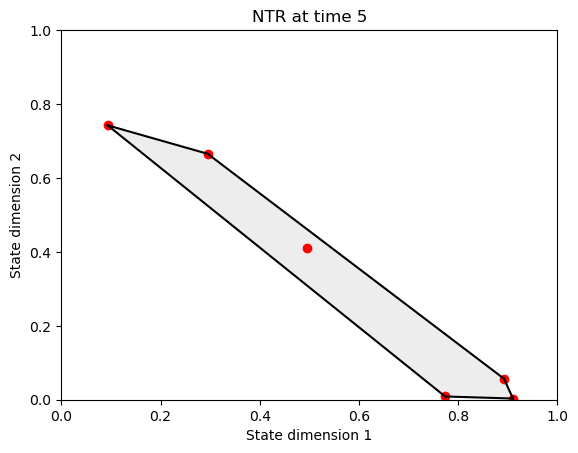

In [22]:
def plot_ntr_at_time(NTR_history, t):
    vertices, hull = NTR_history[t]
    if hull is not None:
        # Plot the convex hull
        plt.figure()
        for simplex in hull.simplices:
            plt.plot(vertices[simplex, 0], vertices[simplex, 1], 'k-')
        plt.fill(vertices[hull.vertices, 0], vertices[hull.vertices, 1], 'lightgray', alpha=0.4)
        plt.scatter(vertices[:, 0], vertices[:, 1], color='red')  # Plot the vertices
        plt.title(f'NTR at time {t}')
        plt.xlabel('State dimension 1')
        plt.ylabel('State dimension 2')
        # Set x and y axis limits
        plt.xlim(0, 1)
        plt.ylim(0, 1)        
        plt.show()
    else:
        print(f"Not enough vertices to form an NTR at time {t}")

# Example: Plot NTR at time t=3
plot_ntr_at_time(Ntr_test, 5)

In [488]:
import torch
import torch.autograd as autograd
import gpytorch
from gpytorch.models import ExactGP
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, MaternKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from cyipopt import minimize_ipopt
import numpy as np

np.random.seed(2001)

# Parameters
T = 10  # Time horizon
D = 2  # Number of risky assets
r = 0.03  # Risk-free return in pct.
Rf = np.exp(r)  # Risk-free return
tau = 0.005  # Transaction cost rate
beta = 0.975  # Discount factor
gamma = 3.5  # Risk aversion coefficient

# Risky assets - deterministic
mu = np.array([0.09, 0.09])
Sigma = np.array([[0.04, 0], [0, 0.04]])

# Define the GPR model with ARD
class GPRegressionModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean()
        self.covar_module = ScaleKernel(MaternKernel(nu=1.5, ard_num_dims=train_x.shape[1]))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
def train_gp_model(train_x, train_y):
    likelihood = GaussianLikelihood(noise_constraint=gpytorch.constraints.GreaterThan(1e-7))  # Reduced noise variance
    model = GPRegressionModel(train_x, train_y, likelihood)
    model.train()
    likelihood.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    mll = ExactMarginalLogLikelihood(likelihood, model)

    training_iterations = 100
    for i in range(training_iterations):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward(retain_graph=True)
        optimizer.step()

    return model, likelihood

# Utility function for wealth (instead of consumption)
def utility_wealth(pi_t1, gamma):
    if gamma == 1:
        return torch.log(pi_t1)
    else:
        return (pi_t1**(1 - gamma)) / (1 - gamma)
    
def safe_utility(pi_t1, gamma):
    # Removed unnecessary re-wrapping of the tensor if it already has requires_grad=True
    pi_t1 = torch.clamp(pi_t1, min=1e-4)  # Prevent log(0) or negative values
    return utility_wealth(pi_t1, gamma)


def normalized_bond_holdings(xt, delta_plus, delta_minus, tau):
    bt = 1.0 - torch.sum((xt + delta_plus - delta_minus)) - tau * (torch.abs(delta_plus - delta_minus))
    # Ensure no negative bond holdings
    bt = torch.clamp(bt, min=1e-6)
    return bt

def normalized_state_dynamics(xt, delta_plus, delta_minus, Rt, bt, Rf):
    pi_t1 = bt * Rf + torch.sum((xt + delta_plus - delta_minus) * Rt)
    pi_t1 = torch.clamp(pi_t1, min=1e-6)  # Avoid division by zero or negative wealth
    xt1 = ((xt + delta_plus - delta_minus) * Rt) / pi_t1
    return pi_t1, xt1

def bellman_equation(vt_next_in, vt_next_out, xt, delta_plus, delta_minus, beta, gamma, tau, Rf, t, T):
    bt = normalized_bond_holdings(xt, delta_plus, delta_minus, tau)

    # Simulate returns for risky assets
    # Rt = torch.tensor(mu + np.random.multivariate_normal(np.zeros(D), Sigma), dtype=torch.float32, requires_grad=True)  # Simulated return
    Rt = torch.tensor(np.random.multivariate_normal(mu, Sigma), dtype=torch.float32, requires_grad=True)  # Simulated return
    # Rt = torch.tensor(mu, dtype=torch.float32, requires_grad=True)  # Simulated return
    Rt = torch.exp(Rt)  # Convert returns (log-normal)

    # Compute next period wealth dynamics
    pi_t1, xt1 = normalized_state_dynamics(xt, delta_plus, delta_minus, Rt, bt, Rf)

    # Compute utility from wealth
    u = safe_utility(pi_t1, gamma)

    # IN FINAL PERIOD WE USE THE TERMINAL VALUE FUNCTION
    if t == T - 1:
        vt_next_val = vt_next_in(xt1.unsqueeze(0))
        # if is_in_ntr(xt1.unsqueeze(0)):
        #     vt_next_val = vt_next_in(xt1.unsqueeze(0))
        # else:
        #     vt_next_val = vt_next_out(xt1.unsqueeze(0))

    # OTHERWISE WE USE THE GPR MODEL
    else:
        if is_in_ntr(xt1.unsqueeze(0)):
            with torch.no_grad():
                vt_next_in.eval()
                vt_next_val = vt_next_in(xt1.unsqueeze(0))
                vt_next_val = vt_next_val.mean
        else:
            with torch.no_grad():
                vt_next_out.eval()
                vt_next_val = vt_next_out(xt1.unsqueeze(0))
                vt_next_val = vt_next_val.mean

    # Bellman equation computation
    vt = u + beta * torch.mean(pi_t1 ** (1 - gamma) * vt_next_val)
    
    if torch.isnan(vt):
        print(f"NaN detected in Bellman equation at time {t}: vt={vt}")
        return torch.tensor(float('nan'))

    return vt

def solve_optimization(xt, vt_next_in,vt_next_out, t, T):
    # Define the number of decision variables (2D for portfolio choices + 1 for consumption only in final period)
    # num_params = 2 * D + (1 if t == T else 0)
    num_params = 2 * D

    def objective(params):
        delta_plus = torch.tensor(params[:D], dtype=torch.float32, requires_grad=True)
        delta_minus = torch.tensor(params[D:2*D], dtype=torch.float32, requires_grad=True)
        
        vt = bellman_equation(vt_next_in, vt_next_out, xt, delta_plus, delta_minus, beta, gamma, tau, Rf, t, T)
        return vt


    def gradient(params):
        delta_plus = torch.tensor(params[:D], dtype=torch.float32, requires_grad=True)
        delta_minus = torch.tensor(params[D:2*D], dtype=torch.float32, requires_grad=True)

        # Compute the value using the Bellman equation
        vt = bellman_equation(vt_next_in, vt_next_out, xt, delta_plus, delta_minus, beta, gamma, tau, Rf, t, T)
        
        # Backpropagate the gradients
        vt.backward()

        grad = np.concatenate([
            delta_plus.grad.detach().numpy(),
            delta_minus.grad.detach().numpy()
        ])
        
        return grad

    def constraints(params):
        delta_plus = torch.tensor(params[:D], dtype=torch.float32, requires_grad=True)
        delta_minus = torch.tensor(params[D:2*D], dtype=torch.float32, requires_grad=True)

        # Compute bond holdings and constraints
        no_borrowing = normalized_bond_holdings(xt, delta_plus, delta_minus, tau).detach()
        
        return torch.cat([delta_plus, delta_minus, torch.tensor([no_borrowing])]).detach().numpy()

        # return constraints_combined.detach().numpy()  # Return the constraints as numpy array


    # Use 0.1 as the initial guess for all params
    initial_guesses = [np.full(num_params, 0.5) for _ in range(6)]
    bounds = [(0, 1)] * D + [(0, 1)] * D  # Correct bounds for delta_plus and delta_minus

    constraints_def = [{'type': 'ineq', 'fun': lambda x: constraints(x)}]
    for initial_guess in initial_guesses:
        result = minimize_ipopt(objective, initial_guess, bounds=bounds, constraints=constraints_def, jac=gradient, options={'tol': 1e-6, 'maxiter': 1000})

        if result.success:
            break

    delta_plus = result.x[:D]
    delta_minus = result.x[D:2*D]

    delta_plus = torch.tensor(delta_plus,dtype=torch.float32,requires_grad=True)
    delta_minus = torch.tensor(delta_minus,dtype=torch.float32,requires_grad=True)

    return delta_plus, delta_minus

def initialize_value_function(T, gamma):
    V = [[None,None] for _ in range(T + 1)]

    def V_terminal(xT):
        return safe_utility(1 - tau * torch.sum(torch.abs(xT)), gamma)

    # Set both vt_next_in and vt_next_out to be this function at terminal time
    V[T][0] = V[T][1] = lambda x: V_terminal(x)

    return V

def filter_invalid_data(inputs, targets):
    valid_mask = ~torch.isnan(targets) & (torch.abs(targets) < 1e10)
    return inputs[valid_mask], targets[valid_mask]


# Sample state points function
def sample_state_points(D):
    points = []
    # Add corners of the simplex (ends)
    for i in range(2 ** D):
        point = [(i >> j) & 1 for j in range(D)]
        points.append(point)
    points.append([0] * D)
    # Add midpoints between all pairs of points
    for i in range(1, 2 ** D):
        for j in range(i):
            midpoint = [(a + b) / 2 for a, b in zip(points[i], points[j])]
            points.append(midpoint)
    # Add more midpoints by sampling regions with higher uncertainty (optional)
    points = [point for point in points if sum(point) <= 1]
    
    # Remove duplicates
    unique_points = []
    for point in points:
        if point not in unique_points:
            unique_points.append(point)
    
    return torch.tensor(unique_points, dtype=torch.float32)

def is_in_ntr(points, bound=0.45):
    # Calculate the sum of portfolio weights
    if points.dim() == 1:
        # If points is 1D, sum over the 0th dimension
        point_sums = torch.sum(points, dim=0)
    else:
        # If points is 2D, sum over the 1st dimension (each row)
        point_sums = torch.sum(points, dim=-1)    
    # Classify points as inside NTR if their sum is less than the bound
    ntr_mask = point_sums < bound
    
    return ntr_mask

def dynamic_programming(T, N, D, gamma, beta, tau, Rf):
    V = initialize_value_function(T, gamma)
    
    def V_terminal(xT):
        return utility(1 - tau * torch.sum(torch.abs(xT)), gamma)

    # Outer loop over time steps
    for t in range(T-1, -1, -1):
        Xt = sample_state_points(D)  # Sample state points for time step t

        vt_values_in = []
        vt_values_out = []
        policies_in = []
        policies_out = []

        # Loop over sampled state points Xt
        for xt in Xt:

            # If we have to use the terminal value function:
            if V[t+1][0] is None or V[t+1][1] is None:
                print(f"At time {T-1}, using V_terminal")
                V[t+1][0] = V_terminal
                V[t+1][1] = V_terminal
            # else:
                # print(f'value function: {V[t+1][0]}')

            # Solve optimization to find policy (delta_plus, delta_minus)
            delta_plus, delta_minus = solve_optimization(xt, V[t+1][0],V[t+1][1], t, T)
            new_holdings = xt + delta_plus - delta_minus

            # Compute value function using Bellman equation
            vt_value = bellman_equation(V[t+1][0], V[t+1][1], xt, delta_plus, delta_minus, beta, gamma, tau, Rf, t, T).item()

            print(f"Time {t}, State {xt.tolist()}: delta_plus = {delta_plus.detach().numpy()}, delta_minus = {delta_minus.detach().numpy()} new holdings: {torch.round(new_holdings, decimals=5).detach().numpy()}")
            
            # Store the results
            if is_in_ntr(xt):
                vt_values_in.append(vt_value)
                policies_in.append((xt, delta_plus, delta_minus))
                
            else:
                vt_values_out.append(vt_value)
                policies_out.append((xt, delta_plus, delta_minus))

        # 2.1: Convert policies and values for inside NTR to tensors and train GPR
        Xt_tensor_in = torch.tensor([x[0].numpy() for x in policies_in], dtype=torch.float32,requires_grad=True)
        vt_values_tensor_in = torch.tensor(vt_values_in, dtype=torch.float32,requires_grad=True)

        # Train GPR for inside NTR if valid data exists
        if len(Xt_tensor_in) > 0:
            V[t][0], _ = train_gp_model(Xt_tensor_in, vt_values_tensor_in)
        else:
            V[t][0] = V_terminal  # No valid data, assign terminal function

        # 2.2: Convert policies and values for outside NTR to tensors and train GPR
        Xt_tensor_out = torch.tensor([x[0].numpy() for x in policies_out], dtype=torch.float32, requires_grad=True)
        vt_values_tensor_out = torch.tensor(vt_values_out, dtype=torch.float32, requires_grad=True)

        # Train GPR for outside NTR if valid data exists
        if len(Xt_tensor_out) > 0:
            V[t][1], _ = train_gp_model(Xt_tensor_out, vt_values_tensor_out)
        else:
            V[t][1] = V_terminal


    return V

# Define parameters and run the algorithm
N = 100  # Number of sample points
V = dynamic_programming(T, N, D, gamma, beta, tau, Rf)

# V now contains the approximated value functions for each time period


ValueError: only one element tensors can be converted to Python scalars

In [211]:
in this example code, are returns log normal?

import torch
import torch.autograd as autograd
import gpytorch
from gpytorch.models import ExactGP
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, MaternKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from cyipopt import minimize_ipopt
import numpy as np
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
from numpy.polynomial.hermite import hermgauss
np.random.seed(2001)

# Parameters
T = 10  # Time horizon
D = 2  # Number of risky assets
r = 0.03  # Risk-free return in pct.
Rf = np.exp(r)  # Risk-free return
tau = 0.005  # Transaction cost rate
beta = 0.975  # Discount factor
gamma = 3.0 # Risk aversion coefficient

# Risky assets - deterministic
mu = np.array([0.07, 0.08])
variance = 0.2**2
Sigma = np.array([[0.15, 0], [0, 0.15]])



# Get Gauss-Hermite quadrature nodes and weights (7 nodes)
nodes, weights = hermgauss(7)
# Assuming Sigma is your covariance matrix
L = np.linalg.cholesky(Sigma)  # Cholesky decomposition
def gauss_hermite_expectation(f, mu, Sigma, D):
    # Perform Cholesky decomposition on the covariance matrix
    L = np.linalg.cholesky(Sigma)
    
    # Gauss-Hermite quadrature nodes and weights
    nodes, weights = hermgauss(7)
    
    # Scale weights for multidimensional case
    weights_prod = np.outer(weights, weights)  # Product of weights for each dimension

    # Multidimensional Gauss-Hermite quadrature using the product rule
    expectation = 0.0
    for idx in np.ndindex(*(7,) * D):  # Iterate over all combinations of nodes
        x = np.array([nodes[i] for i in idx])  # Current combination of nodes
        
        # Calculate transformed random variable using L and mu
        transformed_x = np.sqrt(2) * np.dot(L, x) + mu
        
        # Evaluate function f at the transformed points (detach the tensors here)
        f_value = f(torch.tensor(transformed_x, dtype=torch.float32).detach())  # Detach the tensor from the computation graph
        
        # Accumulate the weighted sum
        expectation += weights_prod[idx] * f_value
    
    return expectation * np.pi ** (-D / 2)

# Define the GPR model with ARD
class GPRegressionModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean()
        self.covar_module = ScaleKernel(MaternKernel(nu=1.5, ard_num_dims=train_x.shape[1]))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

def train_gp_model(train_x, train_y):
    likelihood = GaussianLikelihood(noise_constraint=gpytorch.constraints.GreaterThan(1e-8))  # Reduced noise variance
    model = GPRegressionModel(train_x, train_y, likelihood)
    model.train()
    likelihood.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    mll = ExactMarginalLogLikelihood(likelihood, model)

    training_iterations = 100
    for i in range(training_iterations):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward(retain_graph=True)
        optimizer.step()

    return model, likelihood

# Utility function for wealth (instead of consumption)
def utility_wealth(pi_t1, gamma):
    if gamma == 1:
        return torch.log(pi_t1)
    else:
        return (pi_t1**(1 - gamma)) / (1 - gamma)
    
def safe_utility(pi_t1, gamma):
    # Removed unnecessary re-wrapping of the tensor if it already has requires_grad=True
    pi_t1 = torch.clamp(pi_t1, min=1e-5)  # Prevent log(0) or negative values
    return utility_wealth(pi_t1, gamma)

def normalized_bond_holdings(xt, delta_plus, delta_minus, tau):
    # Element-wise operations to compute total transaction costs
    transaction_costs = tau * (torch.abs(delta_plus) + torch.abs(delta_minus))    
    # Compute the total bond holdings as 1 minus the sum of risky assets and transaction costs
    bt = 1 - torch.sum(xt + delta_plus - delta_minus) - torch.sum(transaction_costs)    
    # Ensure no negative bond holdings, but DO NOT detach here
    bt = torch.clamp(bt, min=0)    
    return bt

def normalized_state_dynamics(xt, delta_plus, delta_minus, Rt, bt, Rf):
    pi_t1 = bt * Rf + torch.sum((xt + delta_plus - delta_minus) * Rt)
    pi_t1 = torch.clamp(pi_t1, min=1e-6)  # Avoid division by zero or negative wealth
    xt1 = ((xt + delta_plus - delta_minus) * Rt) / pi_t1
    return pi_t1, xt1

# def bellman_equation(vt_next_in, vt_next_out, xt, delta_plus, delta_minus, beta, gamma, tau, Rf, t, T):
#     # Compute bond holdings, removed re-wrapping tensors unnecessarily
#     bt = normalized_bond_holdings(xt, delta_plus, delta_minus, tau)

#     # Simulate returns for risky assets
#     Rt = torch.tensor(mu + np.random.multivariate_normal(np.zeros(D), Sigma), dtype=torch.float32, requires_grad=True)  # Simulated return
#     Rt = torch.exp(Rt)  # Convert returns (log-normal)

#     # Compute next period wealth dynamics
#     pi_t1, xt1 = normalized_state_dynamics(xt, delta_plus, delta_minus, Rt, bt, Rf)

#     # Compute utility from wealth
#     u = safe_utility(pi_t1, gamma)

#     # IN FINAL PERIOD WE USE THE TERMINAL VALUE FUNCTION
#     if t == T - 1:
#         if is_in_ntr(xt1.unsqueeze(0)):
#             vt_next_val = vt_next_in(xt1.unsqueeze(0))
#         else:
#             vt_next_val = vt_next_out(xt1.unsqueeze(0))

#     # OTHERWISE WE USE THE GPR MODEL
#     else:
#         if is_in_ntr(xt1.unsqueeze(0)):
#             with torch.no_grad():
#                 vt_next_in.eval()
#                 vt_next_val = vt_next_in(xt1.unsqueeze(0))
#                 vt_next_val = vt_next_val.mean
#         else:
#             with torch.no_grad():
#                 vt_next_out.eval()
#                 vt_next_val = vt_next_out(xt1.unsqueeze(0))
#                 vt_next_val = vt_next_val.mean

#     # Bellman equation computation
#     vt = u + beta * torch.mean(pi_t1 ** (1 - gamma) * vt_next_val)
    
#     if torch.isnan(vt):
#         print(f"NaN detected in Bellman equation at time {t}: vt={vt}")
#         return torch.tensor(float('nan'))

#     # Return the scalar value using .item()
#     return vt

def bellman_equation(vt_next_in, vt_next_out, xt, delta_plus, delta_minus, beta, gamma, tau, Rf, t, T, mu, Sigma, D):
    # Compute bond holdings
    bt = normalized_bond_holdings(xt, delta_plus, delta_minus, tau)

    # Define the function to approximate expected returns f for the risky assets
    def f(Rt):
        pi_t1, xt1 = normalized_state_dynamics(xt, delta_plus, delta_minus, Rt, bt, Rf)
        u = safe_utility(pi_t1, gamma)
        
        # Detach xt1 to ensure it's not tracking gradients
        xt1 = xt1.detach()

        if t == T - 1:
            vt_next_val = vt_next_in(xt1.unsqueeze(0))  # This should match the trained inputs
        else:
            vt_next_val = vt_next_out(xt1.unsqueeze(0))  # This should match the trained inputs
        return u + beta * torch.mean(pi_t1 ** (1.0 - gamma) * vt_next_val)

    # Apply Gauss-Hermite quadrature to compute the expected returns on risky assets
    expected_returns = gauss_hermite_expectation(f, mu, Sigma, D)

    # Update the state dynamics with the computed expected returns
    pi_t1, xt1 = normalized_state_dynamics(xt, delta_plus, delta_minus, expected_returns, bt, Rf)

    # Detach xt1 to avoid issues with gradient tracking
    xt1 = xt1.detach()

    # Compute utility from wealth
    u = safe_utility(pi_t1, gamma)

    # Use the terminal value function in the final period
    if t == T - 1:
        vt_next_val = vt_next_in(xt1.unsqueeze(0))  # Ensure xt1 is properly detached
    else:
        if is_in_ntr(xt1.unsqueeze(0)):
            with torch.no_grad():
                vt_next_in.eval()
                vt_next_val = vt_next_in(xt1.unsqueeze(0))  # Ensure consistency in input format
                vt_next_val = vt_next_val.mean
        else:
            with torch.no_grad():
                vt_next_out.eval()
                vt_next_val = vt_next_out(xt1.unsqueeze(0))  # Ensure consistency in input format
                vt_next_val = vt_next_val.mean

    # Bellman equation computation
    vt = u + beta * torch.mean(pi_t1 ** (1.0 - gamma) * vt_next_val)

    # Certainty equivalent transformation
    vt = ((1.0 - gamma) * vt)**(1.0/(1.0 - gamma))

    if torch.isnan(vt):
        print(f"NaN detected in Bellman equation at time {t}: vt={vt}")
        print(f" gamma = {gamma}, u = {u}, beta = {beta}, pi_t1 = {pi_t1}, vt_next_val = {vt_next_val}")
        return torch.tensor(float('nan'))

    return vt

def solve_optimization(xt, vt_next_in, vt_next_out, t, T, D, beta, gamma, tau, Rf,mu,Sigma):
    num_params = 2 * D

    def objective(params):
        delta_plus = torch.tensor(params[:D], dtype=torch.float32, requires_grad=True)
        delta_minus = torch.tensor(params[D:2*D], dtype=torch.float32, requires_grad=True)
        
        vt = bellman_equation(vt_next_in, vt_next_out, xt, delta_plus, delta_minus, beta, gamma, tau, Rf, t, T,mu,Sigma,D)
        return vt.item()

    def gradient(params):
        delta_plus = torch.tensor(params[:D], dtype=torch.float32, requires_grad=True)
        delta_minus = torch.tensor(params[D:2*D], dtype=torch.float32, requires_grad=True)

        # Compute the value using the Bellman equation
        vt = bellman_equation(vt_next_in, vt_next_out, xt, delta_plus, delta_minus, beta, gamma, tau, Rf, t, T,mu,Sigma,D)
        
        # Backpropagate the gradients
        vt.backward()

        grad = np.concatenate([
            delta_plus.grad.detach().numpy(),
            delta_minus.grad.detach().numpy()
        ])
        
        return grad

    def constraints(params):
        delta_plus = torch.tensor(params[:D], dtype=torch.float32, requires_grad=True)
        delta_minus = torch.tensor(params[D:2*D], dtype=torch.float32, requires_grad=True)
        
        # New holdings after buying and selling risky assets
        new_holdings = xt + delta_plus - delta_minus
        
        # Constraint 1: Ensure no short-selling (i.e., no negative holdings)
        no_shorting_constraint = new_holdings  # This should directly ensure new_holdings >= 0
        
        # Constraint 2: Ensure that the total allocation (risky assets + bond) does not exceed 1
        total_risky_asset_allocation = torch.sum(new_holdings)  # Sum of new holdings for all risky assets
        bt = normalized_bond_holdings(xt, delta_plus, delta_minus, tau)  # Bond holdings
        bt = torch.clamp(bt, min=0)  # Ensure non-negative bond holdings
        total_allocation = total_risky_asset_allocation + bt
        
        # Ensure the total allocation does not exceed 1
        no_over_allocation_constraint = 1.0 - total_allocation  # total_allocation <= 1
        
        # Ensure bond holdings are non-negative
        bond_constraints = bt  # bt >= 0
        
        # Constraint 3: delta (delta_plus - delta_minus) >= -xt (element wise)
        delta_constraint = delta_plus - delta_minus + xt  # delta >= -xt
        
        # Constraint 4: xt + delta (which is xt+1) must also be in [0,1]
        new_holdings_upper_bound = 1.0 - new_holdings  # new_holdings <= 1
        new_holdings_lower_bound = new_holdings  # new_holdings >= 0
        
        # Combine all constraints into one array
        constraints_combined = torch.cat([
            no_shorting_constraint,                # Ensure no short-selling for any asset >= 0
            bond_constraints.unsqueeze(0),         # Ensure bond holdings are non-negative >= 0
            no_over_allocation_constraint.unsqueeze(0),  # Ensure total allocation is <= 1
            delta_constraint,                      # Ensure delta >= -xt
            new_holdings_upper_bound,              # Ensure new_holdings <= 1
            new_holdings_lower_bound               # Ensure new_holdings >= 0
        ])  # DO NOT detach here!
        
        return constraints_combined.detach().numpy()  # Return the constraints as numpy array

    def jacobian(params):
        return np.eye(num_params)

    # Use 0.2 as the initial guess for all params
    initial_guesses = [np.full(num_params, 0.2) for _ in range(6)]
    bounds = [(0, 1)] * D + [(0, 1)] * D  # Correct bounds for delta_plus and delta_minus

    constraints_def = [{'type': 'ineq', 'fun': lambda x: constraints(x)}]
    for initial_guess in initial_guesses:
        result = minimize_ipopt(
            fun=objective,
            x0=initial_guess,
            jac=gradient,
            bounds=bounds,
            constraints={'type': 'ineq', 'fun': constraints, 'jac': jacobian}
        )
        if result.success:
            break

    delta_plus = result.x[:D]
    delta_minus = result.x[D:2*D]

    #Optimal policy
    delta_plus = torch.tensor(delta_plus,dtype=torch.float32,requires_grad=True)
    delta_minus = torch.tensor(delta_minus,dtype=torch.float32,requires_grad=True)
    
    #NTR vertice 
    omega_i_t = xt + delta_plus - delta_minus

    # Return delta_plus and delta_minus, also compute NTR vertices
    return delta_plus, delta_minus, omega_i_t


def V_terminal(xT,tau,gamma):
    return safe_utility(1 - tau * torch.sum(torch.abs(xT)), gamma)

def initialize_value_function(T, tau, gamma):
    V = [[None,None] for _ in range(T + 1)]

    def V_terminal(xT):
        return safe_utility(1 - tau * torch.sum(torch.abs(xT)), gamma)

    # Set both vt_next_in and vt_next_out to be this function at terminal time
    V[T][0] = V_terminal
    V[T][1] = V_terminal

    return V

# Sample state points function
def sample_state_points(D):
    points = []
    # Add corners of the simplex (ends)
    for i in range(2 ** D):
        point = [(i >> j) & 1 for j in range(D)]
        points.append(point)
    points.append([0] * D)
    # Add midpoints between all pairs of points
    for i in range(1, 2 ** D):
        for j in range(i):
            midpoint = [(a + b) / 2 for a, b in zip(points[i], points[j])]
            points.append(midpoint)
    # Add more midpoints by sampling regions with higher uncertainty (optional)
    points = [point for point in points if sum(point) <= 1]
    
    # Remove duplicates
    unique_points = []
    for point in points:
        if point not in unique_points:
            unique_points.append(point)
    
    return torch.tensor(unique_points, dtype=torch.float32)

def is_in_ntr(points, bound=0.45):
    # Calculate the sum of portfolio weights
    if points.dim() == 1:
        # If points is 1D, sum over the 0th dimension
        point_sums = torch.sum(points, dim=0)
    else:
        # If points is 2D, sum over the 1st dimension (each row)
        point_sums = torch.sum(points, dim=-1)    
    # Classify points as inside NTR if their sum is less than the bound
    ntr_mask = point_sums < bound
    
    return ntr_mask

# Approximate the NTR by storing vertices
# def approximate_ntr(vertices):
#     # Approximate NTR as convex combination of vertices
#     lambda_vals = torch.distributions.Dirichlet(torch.ones(len(vertices))).sample()
#     ntr = torch.sum(torch.stack([l * v for l, v in zip(lambda_vals, vertices)]), dim=0)
#     return ntr

def approximate_ntr(vertices):
    # Compute convex hull of the vertices to represent the NTR
    if len(vertices) > 2:  # Convex hull requires at least 3 points
        vertices = torch.stack(vertices).detach().numpy()  # Convert to numpy
        hull = ConvexHull(vertices)  # Compute convex hull
        return vertices, hull
    else:
        # Return the vertices directly if fewer than 3 points are available
        return vertices, None


def dynamic_programming(T, N, D, gamma, beta, tau, Rf,mu,Sigma):
    V = initialize_value_function(T, tau, gamma)
    # Dictionary to store NTR approximations over time
    NTR_history = {}

    # Outer loop over time steps
    for t in range(T-1, -1, -1):
        Xt = sample_state_points(D)  # Sample state points for time step t

        vt_values_in = []
        vt_values_out = []
        policies_in = []
        policies_out = []
        omega_vertices = []

        # Loop over sampled state points Xt
        for xt in Xt:

            # If we have to use the terminal value function:
            if V[t+1][0] is None or V[t+1][1] is None:
                print(f"At time {T-1}, using V_terminal")
                # i want to set V[1] and V[0] as the terminal value function
                V[t+1][0] = V_terminal
                V[t+1][1] = V_terminal

            # Solve optimization to find policy (delta_plus, delta_minus)
            delta_plus, delta_minus, omega_i_t = solve_optimization(xt, V[t+1][0], V[t+1][1], t, T, D, beta, gamma, tau, Rf,mu,Sigma)
            
            # Store NTR vertices for approximation
            omega_vertices.append(omega_i_t)

            new_holdings = xt + delta_plus - delta_minus

            # Compute value function using Bellman equation
            vt_value = bellman_equation(V[t+1][0], V[t+1][1], xt, delta_plus, delta_minus, beta, gamma, tau, Rf, t, T,mu,Sigma,D).item()

            print(f"Time {t}, State {xt.tolist()}: delta_plus = {delta_plus.detach().numpy()}, delta_minus = {delta_minus.detach().numpy()} new holdings: {torch.round(new_holdings, decimals=5).detach().numpy()}")
            
            # Store the results
            if is_in_ntr(xt):
                vt_values_in.append(vt_value)
                policies_in.append((xt, delta_plus, delta_minus))
                
            else:
                vt_values_out.append(vt_value)
                policies_out.append((xt, delta_plus, delta_minus))

        # Approximate the NTR using stored vertices and convex hull
        vertices, hull = approximate_ntr(omega_vertices)
        NTR_history[t] = (vertices, hull)

        # 2.1: Convert policies and values for inside NTR to tensors and train GPR
        Xt_tensor_in = torch.tensor([x[0].numpy() for x in policies_in], dtype=torch.float32,requires_grad=True)
        vt_values_tensor_in = torch.tensor(vt_values_in, dtype=torch.float32,requires_grad=True)

        # Train GPR for inside NTR if valid data exists
        if len(Xt_tensor_in) > 0:
            V[t][0], _ = train_gp_model(Xt_tensor_in, vt_values_tensor_in)
        else:
            V[t][0] = V_terminal  # No valid data, assign terminal function

        # 2.2: Convert policies and values for outside NTR to tensors and train GPR
        Xt_tensor_out = torch.tensor([x[0].numpy() for x in policies_out], dtype=torch.float32, requires_grad=True)
        vt_values_tensor_out = torch.tensor(vt_values_out, dtype=torch.float32, requires_grad=True)

        # Train GPR for outside NTR if valid data exists
        if len(Xt_tensor_out) > 0:
            V[t][1], _ = train_gp_model(Xt_tensor_out, vt_values_tensor_out)
        else:
            V[t][1] = V_terminal


    return V, NTR_history

# Define parameters and run the algorithm
N = 50  # Number of sample points
V,Ntr_test = dynamic_programming(T, N, D, gamma, beta, tau, Rf,mu,Sigma)



Object `normal` not found.
Time 9, State [0.0, 0.0]: delta_plus = [0.66813564 0.9951438 ], delta_minus = [0.3449048 0.9855245] new holdings: [0.32323 0.00962]
Time 9, State [1.0, 0.0]: delta_plus = [0.37770712 0.9192744 ], delta_minus = [0.60084397 0.90654594] new holdings: [0.77686 0.01273]
Time 9, State [0.0, 1.0]: delta_plus = [0.7210735  0.39527205], delta_minus = [0.5708803  0.97253793] new holdings: [0.15019 0.42273]
Time 9, State [0.5, 0.0]: delta_plus = [0.38873592 0.9831241 ], delta_minus = [0.39103204 0.97326684] new holdings: [0.4977  0.00986]
Time 9, State [0.0, 0.5]: delta_plus = [0.35236117 0.25619385], delta_minus = [0.2352529 0.5251859] new holdings: [0.11711 0.23101]
Time 9, State [0.5, 0.5]: delta_plus = [0.42210346 0.5718769 ], delta_minus = [0.48477268 0.98913175] new holdings: [0.43733 0.08275]


RuntimeError: You must train on the training inputs!

# Analysis of the algorithm 1

In [216]:
import torch
import torch.autograd as autograd
import gpytorch
from gpytorch.models import ExactGP
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, MaternKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from cyipopt import minimize_ipopt
import numpy as np
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from numpy.polynomial.hermite import hermgauss

# Get Gauss-Hermite quadrature nodes and weights (7 nodes)
nodes, weights = hermgauss(7)

# Parameters
T = 10  # Time horizon
D = 2  # Number of risky assets
r = 0.01  # Risk-free return in pct.
Rf = r
# Rf = np.exp(r)  # Risk-free return
tau = 0.0001 # Transaction cost rate
beta = 0.975  # Discount factor
gamma = 3.0 # Risk aversion coefficient


# Risky assets - deterministic
mu = np.array([0.07, 0.07])
Sigma = np.array([[0.04, 0], [0, 0.04]])

# Assuming Sigma is your covariance matrix
L = np.linalg.cholesky(Sigma)  # Cholesky decomposition

def gauss_hermite_expectation(f, mu, Sigma, D):
    # Perform Cholesky decomposition on the covariance matrix
    L = np.linalg.cholesky(Sigma)
    
    # Gauss-Hermite quadrature nodes and weights
    nodes, weights = hermgauss(7)
    
    # Scale weights for multidimensional case
    weights_prod = np.outer(weights, weights)  # Product of weights for each dimension

    # Multidimensional Gauss-Hermite quadrature using the product rule
    expectation = 0.0
    for idx in np.ndindex(*(7,) * D):  # Iterate over all combinations of nodes
        x = np.array([nodes[i] for i in idx])  # Current combination of nodes
        
        # Calculate transformed random variable using L and mu
        transformed_x = np.sqrt(2) * np.dot(L, x) + mu
        
        # Evaluate function f at the transformed points (detach the tensors here)
        f_value = f(torch.tensor(transformed_x, dtype=torch.float32).detach())  # Detach the tensor from the computation graph
        
        # Accumulate the weighted sum
        expectation += weights_prod[idx] * f_value
    
    return expectation * np.pi ** (-D / 2)

# Define the GPR model with ARD
class GPRegressionModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean()
        self.covar_module = ScaleKernel(MaternKernel(nu=1.5, ard_num_dims=train_x.shape[1]))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
def train_gp_model(train_x, train_y):
    likelihood = GaussianLikelihood(noise_constraint=gpytorch.constraints.GreaterThan(1e-6))  # Reduced noise variance
    model = GPRegressionModel(train_x, train_y, likelihood)
    model.train()
    likelihood.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    mll = ExactMarginalLogLikelihood(likelihood, model)

    training_iterations = 300
    for i in range(training_iterations):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward(retain_graph=True)
        optimizer.step()

    return model, likelihood


# Utility function for wealth (instead of consumption)
def utility_wealth(pi_t1, gamma):
    if gamma == 1:
        return torch.log(pi_t1)
    else:
        return (pi_t1**(1.0 - gamma)) / (1 - gamma)
        # return pi_t1**((1.0 - gamma))**(1/(1 - gamma))
    
def safe_utility(pi_t1, gamma):
    # Removed unnecessary re-wrapping of the tensor if it already has requires_grad=True
    pi_t1 = torch.clamp(pi_t1, min=1e-4)  # Prevent log(0) or negative values
    return utility_wealth(pi_t1, gamma)

def normalized_bond_holdings(xt, delta_plus, delta_minus, tau):
    # Element-wise operations to compute total transaction costs
    transaction_costs = tau * (torch.abs(delta_plus - delta_minus))
    # Compute the total bond holdings as 1 minus the sum of risky assets and transaction costs
    bt = 1.0 - torch.sum(xt + delta_plus - delta_minus) - torch.sum(transaction_costs)
    # Ensure no negative bond holdings, but DO NOT detach here
    bt = torch.clamp(bt, min=0)
    return bt

def normalized_state_dynamics(xt, delta_plus, delta_minus, Rt, bt, Rf):
    # Apply returns independently to each asset holding
    delta = delta_plus - delta_minus
    pi_t1 = bt * Rf + torch.sum((xt + delta) * Rt)
    pi_t1 = torch.clamp(pi_t1, min=1e-8)  # Avoid division by zero or negative wealth
    
    # Update asset holdings using the corresponding returns for each asset
    xt1 = (xt + delta_plus - delta_minus) * Rt / pi_t1
    return pi_t1, xt1


def bellman_equation(vt_next_in, vt_next_out, xt, delta_plus, delta_minus, beta, gamma, tau, Rf, t, T,mu,Sigma,D):
    # Compute bond holdings, removed re-wrapping tensors unnecessarily
    bt = normalized_bond_holdings(xt, delta_plus, delta_minus, tau)

    # Simulate returns for risky assets
    
    # Rt = torch.tensor(np.random.multivariate_normal(mu, Sigma), dtype=torch.float32, requires_grad=True)  # Simulated return
    Rt = torch.tensor(mu, dtype=torch.float32, requires_grad=True)  # Simulated return

    # Compute next period wealth dynamics
    pi_t1, xt1 = normalized_state_dynamics(xt, delta_plus, delta_minus, Rt, bt, Rf)

    # Compute utility from wealth
    u = safe_utility(pi_t1, gamma)

    # IN FINAL PERIOD WE USE THE TERMINAL VALUE FUNCTION
    if t == T - 1:
        if is_in_ntr(xt1.unsqueeze(0)):
            vt_next_val = vt_next_in(xt1.unsqueeze(0))
        else:
            vt_next_val = vt_next_out(xt1.unsqueeze(0))

    # OTHERWISE WE USE THE GPR MODEL
    else:
        if is_in_ntr(xt1.unsqueeze(0)):
            with torch.no_grad():
                vt_next_in.eval()
                vt_next_val = vt_next_in(xt1.unsqueeze(0))
                vt_next_val = vt_next_val.mean
        else:
            with torch.no_grad():
                vt_next_out.eval()
                vt_next_val = vt_next_out(xt1.unsqueeze(0))
                vt_next_val = vt_next_val.mean

    # Bellman equation computation
    vt = u + beta * torch.mean(pi_t1 ** (1 - gamma) * vt_next_val)
    
    if torch.isnan(vt):
        print(f"NaN detected in Bellman equation at time {t}: vt={vt}")
        return torch.tensor(float('nan'))

    # Return the scalar value using .item()
    return vt

def bellman_equation(vt_next_in, vt_next_out, xt, delta_plus, delta_minus, beta, gamma, tau, Rf, t, T, mu, Sigma, D):
    # Compute bond holdings
    bt = normalized_bond_holdings(xt, delta_plus, delta_minus, tau)

    # Define the function to approximate expected returns f for the risky assets
    def f(Rt):
        pi_t1, xt1 = normalized_state_dynamics(xt, delta_plus, delta_minus, Rt, bt, Rf)
        u = safe_utility(pi_t1, gamma)
        if t == T - 1:
            vt_next_val = vt_next_in(xt1.unsqueeze(0))
        else:
            vt_next_val = vt_next_out(xt1.unsqueeze(0))
        return u + beta * torch.mean(pi_t1 ** (1.0 - gamma) * vt_next_val)

    # Apply Gauss-Hermite quadrature to compute the expected returns on risky assets
    expected_returns = gauss_hermite_expectation(f, mu, Sigma, D)

    # Update the state dynamics with the computed expected returns
    pi_t1, xt1 = normalized_state_dynamics(xt, delta_plus, delta_minus, expected_returns, bt, Rf)

    # Compute utility from wealth
    u = safe_utility(pi_t1, gamma)

    # Use the terminal value function in the final period
    if t == T - 1:
        vt_next_val = vt_next_in(xt1.unsqueeze(0))
    else:
        if is_in_ntr(xt1.unsqueeze(0)):
            with torch.no_grad():
                vt_next_in.eval()
                vt_next_val = vt_next_in(xt1.unsqueeze(0))
                vt_next_val = vt_next_val.mean
        else:
            with torch.no_grad():
                vt_next_out.eval()
                vt_next_val = vt_next_out(xt1.unsqueeze(0))
                vt_next_val = vt_next_val.mean

    # Bellman equation computation
    vt = u + beta * torch.mean(pi_t1 ** (1.0 - gamma) * vt_next_val)

    # Certainty equivalent transformation
    vt = ((1.0 - gamma) * vt)**(1.0/(1.0 - gamma))

    if torch.isnan(vt):
        print(f"NaN detected in Bellman equation at time {t}: vt={vt}")
        print(f" gamma = {gamma}, u = {u}, beta = {beta}, pi_t1 = {pi_t1}, vt_next_val = {vt_next_val}")
        return torch.tensor(float('nan'))

    return vt

def solve_optimization(xt, vt_next_in, vt_next_out, t, T, D, beta, gamma, tau, Rf,mu,Sigma):
    num_params = 2 * D

    def objective(params):
        delta_plus = torch.tensor(params[:D], dtype=torch.float32, requires_grad=True)
        delta_minus = torch.tensor(params[D:2*D], dtype=torch.float32, requires_grad=True)
        
        vt = bellman_equation(vt_next_in, vt_next_out, xt, delta_plus, delta_minus, beta, gamma, tau, Rf, t, T,mu,Sigma,D)
        return vt.item()

    def gradient(params):
        delta_plus = torch.tensor(params[:D], dtype=torch.float32, requires_grad=True)
        delta_minus = torch.tensor(params[D:2*D], dtype=torch.float32, requires_grad=True)

        # Compute the value using the Bellman equation
        vt = bellman_equation(vt_next_in, vt_next_out, xt, delta_plus, delta_minus, beta, gamma, tau, Rf, t, T,mu,Sigma,D)
        
        # Backpropagate the gradients
        vt.backward()

        grad = np.concatenate([
            delta_plus.grad.detach().numpy(),
            delta_minus.grad.detach().numpy()
        ])
        
        return grad

    # Constraints definition
    def constraints(params):
        delta_plus = torch.tensor(params[:D], dtype=torch.float32,requires_grad=True)
        delta_minus = torch.tensor(params[D:2*D], dtype=torch.float32,requires_grad=True)

        # Constraint 1: delta_plus >= 0
        constraint_1 = delta_plus

        # Constraint 2: delta_minus >= 0
        constraint_2 = delta_minus

        # Constraint 3: delta_minus <= xt (can't sell more than you have)
        constraint_3 = xt + delta_plus - delta_minus

        # Constraint 4: bond holdings (b_t >= 0)
        b_t = normalized_bond_holdings(xt, delta_plus, delta_minus, tau)
        constraint_4 = b_t

        # Constraint 5: Total portfolio sum <= 1 (1^T * (xt + delta_plus - delta_minus) + b_t <= 1)
        total_sum = torch.sum(xt + delta_plus - delta_minus) + b_t
        constraint_5 = 1.0 - total_sum

        # Combine all constraints into a tensor and return
        constraints_combined = torch.cat([
            constraint_1,  # delta_plus >= 0
            constraint_2,  # delta_minus >= 0
            constraint_3,  # delta_minus <= xt
            constraint_4.unsqueeze(0),  # b_t >= 0
            constraint_5.unsqueeze(0),   # total portfolio sum <= 1
        ])
        return constraints_combined.detach().numpy()  # Return the constraints as a numpy array

    def jacobian(params):
        return np.eye(num_params)
    
    initial_guesses = [np.full(num_params, 0.2) for _ in range(6)]
    # bounds = [(0.0, 1.0)] * D + [(0.0, 1.0)] * D  # Correct bounds for delta_plus and delta_minus
    bounds = [(0, 1)] * D + [(0, 1)] * D  # Correct bounds for delta_plus and delta_minus

    constraints_def = [{'type': 'ineq', 'fun': lambda x: constraints(x)}]
    for initial_guess in initial_guesses:
        # result = minimize_ipopt(objective, initial_guess, bounds=bounds, constraints=constraints_def, jac=gradient, options={'tol': 1e-5, 'maxiter': 1000})
        result = minimize_ipopt(objective, initial_guess, bounds=bounds, jac=gradient, 
                                constraints={'type': 'ineq', 'fun': constraints, 'jac': jacobian},
                                options={'tol': 1e-6, 'maxiter': 100})

        if result.success:
            break
    delta_plus = result.x[:D]
    delta_minus = result.x[D:2*D]

    #Optimal policy
    delta_plus = torch.tensor(delta_plus,dtype=torch.float32,requires_grad=True)
    delta_minus = torch.tensor(delta_minus,dtype=torch.float32,requires_grad=True)
    
    #NTR vertice 
    omega_i_t = xt + delta_plus - delta_minus

    # Return delta_plus and delta_minus, also compute NTR vertices
    return delta_plus, delta_minus, omega_i_t

def V_terminal(xT,tau,gamma):
    # return safe_utility(1.0 - tau * torch.sum(torch.abs(xT)), gamma)
    return safe_utility(1.0 - tau * torch.sum(torch.abs(xT)), gamma)

def initialize_value_function(T, tau, gamma):
    V = [[None,None] for _ in range(T + 1)]
    # Set both vt_next_in and vt_next_out to be this function at terminal time
    V[T][0] = V_terminal
    V[T][1] = V_terminal
    return V

def sample_state_points(D):
    points = []
    
    # Add corners of the simplex (ends)
    for i in range(2 ** D):
        point = [(i >> j) & 1 for j in range(D)]
        points.append(point)
    
    # Add the origin point (0, 0)
    points.append([0] * D)
    
    # Add midpoints only between the correct pairs
    for i in range(1, 2 ** D):
        for j in range(i):
            midpoint = [(a + b) / 2 for a, b in zip(points[i], points[j])]
            if sum(midpoint) == 1:  # Ensure midpoints are on the simplex
                points.append(midpoint)
    
    # Filter points that sum to 1 or less (simplex constraint)
    points = [point for point in points if sum(point) == 1 or sum(point) == 0]
    
    # Remove duplicates
    unique_points = []
    for point in points:
        if point not in unique_points:
            unique_points.append(point)
    
    return torch.tensor(unique_points, dtype=torch.float32)



# def dynamic_programming(T, N, D, gamma, beta, tau, Rf):
#     V = initialize_value_function(T, tau, gamma)
#     # Dictionary to store NTR approximations over time
#     NTR_history = {}

#     # Outer loop over time steps
#     for t in range(T-1, -1, -1):
#         Xt = sample_state_points(D)  # Sample state points for time step t

#         vt_values_in = []
#         vt_values_out = []
#         policies_in = []
#         policies_out = []
#         omega_vertices = []

#         # Loop over sampled state points Xt
#         for xt in Xt:

#             # If we have to use the terminal value function:
#             if V[t+1][0] is None or V[t+1][1] is None:
#                 print(f"At time {T-1}, using V_terminal")
#                 # i want to set V[1] and V[0] as the terminal value function
#                 V[t+1][0] = V_terminal
#                 V[t+1][1] = V_terminal

#             # Solve optimization to find policy (delta_plus, delta_minus)
#             delta_plus, delta_minus, omega_i_t = solve_optimization(xt, V[t+1][0], V[t+1][1], t, T, D, beta, gamma, tau, Rf)
            
#             # Store NTR vertices for approximation
#             omega_vertices.append(omega_i_t)

#             new_holdings = xt + delta_plus - delta_minus

#             # Compute value function using Bellman equation
#             vt_value = bellman_equation(V[t+1][0], V[t+1][1], xt, delta_plus, delta_minus, beta, gamma, tau, Rf, t, T).item()

#             print(f"Time {t}, State {xt.tolist()}: delta_plus = {delta_plus.detach().numpy()}, delta_minus = {delta_minus.detach().numpy()} new holdings: {torch.round(new_holdings, decimals=5).detach().numpy()}")
            
#             # Store the results
#             if is_in_ntr(xt):
#                 vt_values_in.append(vt_value)
#                 policies_in.append((xt, delta_plus, delta_minus))
                
#             else:
#                 vt_values_out.append(vt_value)
#                 policies_out.append((xt, delta_plus, delta_minus))

#         # Approximate the NTR using stored vertices and convex hull
#         vertices, hull = approximate_ntr(omega_vertices)
#         NTR_history[t] = (vertices, hull)

#         # 2.1: Convert policies and values for inside NTR to tensors and train GPR
#         Xt_tensor_in = torch.tensor([x[0].numpy() for x in policies_in], dtype=torch.float32,requires_grad=True)
#         vt_values_tensor_in = torch.tensor(vt_values_in, dtype=torch.float32,requires_grad=True)

#         # Train GPR for inside NTR if valid data exists
#         if len(Xt_tensor_in) > 0:
#             V[t][0], _ = train_gp_model(Xt_tensor_in, vt_values_tensor_in)
#         else:
#             V[t][0] = V_terminal  # No valid data, assign terminal function

#         # 2.2: Convert policies and values for outside NTR to tensors and train GPR
#         Xt_tensor_out = torch.tensor([x[0].numpy() for x in policies_out], dtype=torch.float32, requires_grad=True)
#         vt_values_tensor_out = torch.tensor(vt_values_out, dtype=torch.float32, requires_grad=True)

#         # Train GPR for outside NTR if valid data exists
#         if len(Xt_tensor_out) > 0:
#             V[t][1], _ = train_gp_model(Xt_tensor_out, vt_values_tensor_out)
#         else:
#             V[t][1] = V_terminal

#     return V, NTR_history

def dynamic_programming(T, N, D, gamma, beta, tau, Rf,mu,Sigma):
    V = initialize_value_function(T, tau, gamma)
    NTR_history = {}

    for t in range(T-1, -1, -1):
        Xt = sample_state_points(D)  # Sample state points for time step t

        vt_values_in = []
        vt_values_out = []
        policies_in = []
        policies_out = []
        omega_vertices = []

        for xt in Xt:
            # Use terminal function if necessary
            if V[t+1][0] is None or V[t+1][1] is None:
                V[t+1][0] = V_terminal
                V[t+1][1] = V_terminal

            # Solve optimization to find policy (delta_plus, delta_minus)
            delta_plus, delta_minus, omega_i_t = solve_optimization(xt, V[t+1][0], V[t+1][1], t, T, D, beta, gamma, tau, Rf,mu,Sigma)

            # Store NTR vertices
            omega_vertices.append(omega_i_t)

            new_holdings = xt + delta_plus - delta_minus
            vt_value = bellman_equation(V[t+1][0], V[t+1][1], xt, delta_plus, delta_minus, beta, gamma, tau, Rf, t, T,mu, Sigma, D).item()

            # Separate in and out of NTR
            if is_in_ntr(xt):
                vt_values_in.append(vt_value)
                policies_in.append((xt, delta_plus, delta_minus))
            else:
                vt_values_out.append(vt_value)
                policies_out.append((xt, delta_plus, delta_minus))

        # Approximate NTR using stored vertices
        vertices, hull = approximate_ntr(omega_vertices)
        NTR_history[t] = (vertices, hull)

        # Train GP models only if valid data exists
        if len(policies_in) > 0:
            Xt_tensor_in = torch.tensor([x[0].numpy() for x in policies_in], dtype=torch.float32)
            vt_values_tensor_in = torch.tensor(vt_values_in, dtype=torch.float32)
            V[t][0], _ = train_gp_model(Xt_tensor_in, vt_values_tensor_in)
        else:
            V[t][0] = V_terminal

        if len(policies_out) > 0:
            Xt_tensor_out = torch.tensor([x[0].numpy() for x in policies_out], dtype=torch.float32)
            vt_values_tensor_out = torch.tensor(vt_values_out, dtype=torch.float32)
            V[t][1], _ = train_gp_model(Xt_tensor_out, vt_values_tensor_out)
        else:
            V[t][1] = V_terminal

    return V, NTR_history


# Define parameters and run the algorithm
N = 100  # Number of sample points
V,Ntr_test = dynamic_programming(T, N, D, gamma, beta, tau, Rf,mu,Sigma)

#plot ntr_test

NaN detected in Bellman equation at time 8: vt=nan
NaN detected in Bellman equation at time 8: vt=nan
NaN detected in Bellman equation at time 8: vt=nan


/opt/anaconda3/envs/Peytz2/lib/python3.11/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

# From scratch (Hermite)

In [295]:
import torch
import torch.autograd as autograd
import gpytorch
from gpytorch.models import ExactGP
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, MaternKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from cyipopt import minimize_ipopt
import numpy as np
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from numpy.polynomial.hermite import hermgauss

# Get Gauss-Hermite quadrature nodes and weights (7 nodes)
nodes, weights = hermgauss(7)

# Parameters
T = 10  # Time horizon
D = 2  # Number of risky assets
r = 0.01  # Risk-free return in pct.
Rf = r
# Rf = np.exp(r)  # Risk-free return
tau = 0.001 # Transaction cost rate
beta = 0.975  # Discount factor
gamma = 3.0 # Risk aversion coefficient


# Risky assets - deterministic
mu = np.array([0.08, 0.08])
Sigma = np.array([[0.04, 0], [0, 0.04]])

# Assuming Sigma is your covariance matrix
L = np.linalg.cholesky(Sigma)  # Cholesky decomposition

def gauss_hermite_expectation_vt(vt_next, xt, delta_plus, delta_minus, beta, gamma, tau, Rf, mu, Sigma, D):
    """
    Estimate the conditional expectation E[pi_{t+1}^{1-gamma} * v_{t+1}(x_{t+1})] using Gauss-Hermite quadrature.
    
    Parameters:
    - vt_next: Value function for the next period.
    - xt: Current portfolio allocation at time t.
    - delta_plus, delta_minus: Portfolio adjustments at time t.
    - beta: Discount factor.
    - gamma: Risk aversion coefficient.
    - tau: Transaction cost rate.
    - Rf: Risk-free return.
    - mu: Mean returns for risky assets.
    - Sigma: Covariance matrix for risky asset returns.
    - D: Number of risky assets.
    
    Returns:
    - Approximation of E[pi_{t+1}^{1-gamma} * v_{t+1}(x_{t+1})].
    """
    
    # Perform Cholesky decomposition on the covariance matrix
    L = np.linalg.cholesky(Sigma)
    
    # Gauss-Hermite quadrature nodes and weights (7 nodes in each dimension)
    nodes, weights = hermgauss(7)
    
    # Initialize expectation
    expectation = 0.0
    
    # Iterate over all combinations of nodes for the risky asset returns
    for idx in np.ndindex(*(7,) * D):
        # Transform the Gauss-Hermite nodes to risky asset returns (R_t)
        x = np.array([nodes[i] for i in idx])
        Rt = np.sqrt(2) * np.dot(L, x) + mu
        
        # Compute state dynamics pi_{t+1} and x_{t+1}
        pi_t1, xt1 = normalized_state_dynamics(xt, delta_plus, delta_minus, Rt, Rf, tau)
        
        # Evaluate pi_{t+1}^{1-gamma} * v_{t+1}(x_{t+1})
        if vt_next == terminal_value_function:
            vt_next_val = vt_next(xt1.unsqueeze(0), tau, gamma)
        else:
            vt_next_val = vt_next(xt1.unsqueeze(0))  # Future value function at xt1
        vt_term = vt_next_val 
        # vt_term = (pi_t1 ** (1.0 - gamma)) * vt_next_val
        
        # Accumulate the weighted sum for the expectation
        weight_prod = np.prod([weights[i] for i in idx])
        expectation += weight_prod * vt_term
    
    # Return the weighted expectation (account for normalization factor)
    return expectation * np.pi ** (-D / 2)

# ECONOMIC FUNCTIONS

def utility(pi_t1, gamma):
    if gamma == 1:
        return torch.log(pi_t1)  # Log utility for risk aversion coefficient gamma = 1
    else:
        return (pi_t1**(1.0 - gamma)) / (1 - gamma)  # Power utility for other gamma values
    
def safe_utility(pi_t1, gamma):
    # Removed unnecessary re-wrapping of the tensor if it already has requires_grad=True
    pi_t1 = torch.clamp(pi_t1, min=1e-10)  # Prevent log(0) or negative values
    return utility_wealth(pi_t1, gamma)

def normalized_state_dynamics(xt, delta_plus, delta_minus, Rt, bt, Rf):
    delta = delta_plus - delta_minus
    
    # equation 7
    pi_t1 = bt * Rf + torch.sum((xt + delta) * Rt)
    pi_t1 = torch.clamp(pi_t1, min=1e-10)  # Avoid division by zero or negative wealth    
    
    # Equation 9
    xt1 = (xt + delta_plus - delta_minus) * Rt / pi_t1
    return pi_t1, xt1

def normalized_bond_holdings(xt, delta_plus, delta_minus, tau):
    delta = delta_plus - delta_minus
    
    transaction_costs = tau * torch.sum(torch.abs(delta))
    # Compute the total bond holdings as 1 minus the sum of risky assets and transaction costs
    bt = 1.0 - ( torch.sum(xt + delta_plus - delta_minus) - transaction_costs )
    # Ensure no negative bond holdings, but DO NOT detach here
    bt = torch.clamp(bt, min=0)
    return bt

def update_portfolio_allocation(xt, delta_plus, delta_minus, Rt, pi_t1):
    # Equation 9: Update asset holdings using the corresponding returns for each asset
    xt1 = (xt + delta_plus - delta_minus) * Rt / pi_t1
    return xt1

def expectation(gamma, pi_t1, vt1, xt1, mu, Sigma, D):
    def f(x):
        return vt1(torch.tensor(x, dtype=torch.float32).detach()) * pi_t1 ** (1.0 - gamma)
    return gauss_hermite_expectation(f, mu, Sigma, D)

def value_function_update(ct, gamma, beta, expectation):
    if ct is None:
        ct = 0.0
    utility = safe_utility(pi_t1=ct, gamma=gamma)
    return utility + beta * expectation


def terminal_value_function(xT, tau, gamma):
    return safe_utility(1.0 - tau * torch.sum(torch.abs(xT)), gamma)

def initialize_value_function(T, xt,tau, gamma):
    V = [[None,None] for _ in range(T + 1)]
    # Set both vt_next_in and vt_next_out to be this function at terminal time
    V[T][0] = terminal_value_function(xt, tau, gamma)
    V[T][1] = terminal_value_function( xt, tau, gamma)
    return V


def sample_state_points(D):
    points = []    
    # Add corners of the simplex (ends)
    for i in range(2 ** D):
        point = [(i >> j) & 1 for j in range(D)]
        points.append(point)
    
    # Add the origin point (0, 0)
    points.append([0] * D)   
    # Add midpoints only between the correct pairs
    for i in range(1, 2 ** D):
        for j in range(i):
            midpoint = [(a + b) / 2 for a, b in zip(points[i], points[j])]
            if sum(midpoint) == 1:  # Ensure midpoints are on the simplex
                points.append(midpoint)    
    # Filter points that sum to 1 or less (simplex constraint)
    points = [point for point in points if sum(point) == 1 or sum(point) == 0]   
    # Remove duplicates
    unique_points = []
    for point in points:
        if point not in unique_points:
            unique_points.append(point)    
    return torch.tensor(unique_points, dtype=torch.float32)

def bellman_equation(vt_next_in, vt_next_out, xt, delta_plus, delta_minus, beta, gamma, tau, Rf, t, T, mu, Sigma, D):
    """
    Computes the Bellman value using the current state, portfolio adjustments, and 
    value functions for the next period.

    Parameters:
    - vt_next_in, vt_next_out: Value functions for the next time step (in and out of NTR).
    - xt: Current portfolio allocation at time t.
    - delta_plus, delta_minus: Portfolio adjustments.
    - beta: Discount factor.
    - gamma: Risk aversion coefficient.
    - tau: Transaction cost rate.
    - Rf: Risk-free rate.
    - t: Current time step.
    - T: Final time step.
    - mu: Mean returns for the risky assets.
    - Sigma: Covariance matrix of the risky assets.
    - D: Number of risky assets.
    
    Returns:
    - Bellman value for the current state and portfolio adjustments.
    """

    # Compute bond holdings
    bt = normalized_bond_holdings(xt, delta_plus, delta_minus, tau)

    # Apply Gauss-Hermite quadrature to compute the expected returns on risky assets
    expected_value = gauss_hermite_expectation_vt(
        vt_next=(vt_next_in if t == T - 1 else vt_next_out),
        xt=xt, 
        delta_plus=delta_plus, 
        delta_minus=delta_minus, 
        beta=beta, 
        gamma=gamma, 
        tau=tau, 
        Rf=Rf, 
        mu=mu, 
        Sigma=Sigma, 
        D=D
    )

    # Update the state dynamics with the computed expected returns
    pi_t1, xt1 = normalized_state_dynamics(xt, delta_plus, delta_minus, expected_value, bt, Rf)

    # Compute utility from wealth (current period)
    u = safe_utility(pi_t1, gamma)

    # Check if this is the terminal period
    if t == T - 1:
        vt_next_val = vt_next_in(xt1.unsqueeze(0), tau, gamma)
    else:
        # Determine if in no-trade region (NTR)
        if is_in_ntr(xt1.unsqueeze(0)):
            with torch.no_grad():
                vt_next_in.eval()
                vt_next_val = vt_next_in(xt1.unsqueeze(0)).mean
        else:
            with torch.no_grad():
                vt_next_out.eval()
                vt_next_val = vt_next_out(xt1.unsqueeze(0)).mean

    # Bellman equation computation
    vt = u + beta * torch.mean(pi_t1 ** (1.0 - gamma) * vt_next_val)

    # Certainty equivalent transformation for the value function
    vt = ((1.0 - gamma) * vt) ** (1.0 / (1.0 - gamma))

    if torch.isnan(vt):
        print(f"NaN detected in Bellman equation at time {t}: vt={vt}")
        print(f" gamma = {gamma}, u = {u}, beta = {beta}, pi_t1 = {pi_t1}, vt_next_val = {vt_next_val}")
        return torch.tensor(float('nan'))

    return vt

# Gauss hermite and scipy

In [481]:
import torch
import torch.autograd as autograd
import gpytorch
from gpytorch.models import ExactGP
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, MaternKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from cyipopt import minimize_ipopt
import numpy as np
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from numpy.polynomial.hermite import hermgauss

# Get Gauss-Hermite quadrature nodes and weights (7 nodes)
nodes, weights = hermgauss(7)

# Parameters
T = 10  # Time horizon
D = 2  # Number of risky assets
r = 0.01  # Risk-free return in pct.
Rf = r
# Rf = np.exp(r)  # Risk-free return
tau = 0.001 # Transaction cost rate
beta = 0.975  # Discount factor
gamma = 3.0 # Risk aversion coefficient

dtype = torch.float32

# Risky assets - deterministic
mu = np.array([0.2, 0.1])
Sigma = np.array([[0.04, 0], [0, 0.04]])

# Assuming Sigma is your covariance matrix
L = np.linalg.cholesky(Sigma)  # Cholesky decomposition

def gauss_hermite_expectation_vt(vt_next, xt, delta_plus, delta_minus, beta, gamma, tau, Rf, mu, Sigma, D):

    
    # Perform Cholesky decomposition on the covariance matrix
    L = np.linalg.cholesky(Sigma)
    
    # Gauss-Hermite quadrature nodes and weights (7 nodes in each dimension)
    nodes, weights = hermgauss(7)
    
    # Initialize expectation
    expectation = 0.0
    
    # Iterate over all combinations of nodes for the risky asset returns
    for idx in np.ndindex(*(7,) * D):
        # Transform the Gauss-Hermite nodes to risky asset returns (R_t)
        x = np.array([nodes[i] for i in idx])
        Log_Rt = np.sqrt(2) * np.dot(L, x) + mu
        Rt = np.exp(Log_Rt)
        Rt = torch.tensor(Rt, dtype=dtype)
        
        # Compute state dynamics pi_{t+1} and x_{t+1}
        pi_t1, xt1 = normalized_state_dynamics(xt, delta_plus, delta_minus, Rt, Rf, tau)
        vt_next = terminal_value_function

        # Evaluate pi_{t+1}^{1-gamma} * v_{t+1}(x_{t+1})
        if vt_next == terminal_value_function:
            vt_next_val = vt_next(xt1.unsqueeze(0), tau, gamma)
        else:
            vt_next_val = vt_next(xt1.unsqueeze(0))  # Future value function at xt1
            
        # vt_term = vt_next_val 
        # vt_term = (pi_t1 ** (1.0 - gamma)) * vt_next_val
        
        # Accumulate the weighted sum for the expectation
        weight_prod = np.prod([weights[i] for i in idx])
        expectation += weight_prod * vt_term
    
    # Return the weighted expectation (account for normalization factor)
    return expectation * np.pi ** (-D / 2)

# ECONOMIC FUNCTIONS

def utility(pi_t1, gamma):
    if gamma == 1:
        return torch.log(pi_t1)  # Log utility for risk aversion coefficient gamma = 1
    else:
        return (pi_t1**(1.0 - gamma)) / (1 - gamma)  # Power utility for other gamma values
    
def safe_utility(pi_t1, gamma):
    # Removed unnecessary re-wrapping of the tensor if it already has requires_grad=True
    pi_t1 = torch.clamp(pi_t1, min=1e-10)  # Prevent log(0) or negative values
    return utility_wealth(pi_t1, gamma)

def normalized_state_dynamics(xt, delta_plus, delta_minus, Rt, bt, Rf):
    delta = delta_plus - delta_minus
    
    # equation 7
    pi_t1 = bt * Rf + torch.sum((xt + delta) * Rt)
    pi_t1 = torch.clamp(pi_t1, min=1e-10)  # Avoid division by zero or negative wealth    
    
    # Equation 9
    xt1 = (xt + delta_plus - delta_minus) * Rt / pi_t1
    return pi_t1, xt1

def normalized_bond_holdings(xt, delta_plus, delta_minus, tau):
    delta = delta_plus - delta_minus
    
    transaction_costs = tau * torch.sum(torch.abs(delta))
    # Compute the total bond holdings as 1 minus the sum of risky assets and transaction costs
    bt = 1.0 - ( torch.sum(xt + delta_plus - delta_minus) - transaction_costs )
    # Ensure no negative bond holdings, but DO NOT detach here
    bt = torch.clamp(bt, min=0)
    return bt

def update_portfolio_allocation(xt, delta_plus, delta_minus, Rt, pi_t1):
    # Equation 9: Update asset holdings using the corresponding returns for each asset
    xt1 = (xt + delta_plus - delta_minus) * Rt / pi_t1
    return xt1

def expectation(gamma, pi_t1, vt1, xt1, mu, Sigma, D):
    def f(x):
        return vt1(torch.tensor(x, dtype=dtype).detach()) * pi_t1 ** (1.0 - gamma)
    return gauss_hermite_expectation(f, mu, Sigma, D)

def value_function_update(ct, gamma, beta, expectation):
    if ct is None:
        ct = 0.0
    utility = safe_utility(pi_t1=ct, gamma=gamma)
    return utility + beta * expectation


def terminal_value_function(xT, tau, gamma):
    return safe_utility(1.0 - tau * torch.sum(torch.abs(xT)), gamma)

def initialize_value_function(T, tau, gamma):
    V = [[None,None] for _ in range(T + 1)]
    # Set both vt_next_in and vt_next_out to be this function at terminal time
    V[T][0] = terminal_value_function
    V[T][1] = terminal_value_function
    return V


def sample_state_points(D):
    points = []    
    # Add corners of the simplex (ends)
    for i in range(2 ** D):
        point = [(i >> j) & 1 for j in range(D)]
        points.append(point)
    
    # Add the origin point (0, 0)
    points.append([0] * D)   
    # Add midpoints only between the correct pairs
    for i in range(1, 2 ** D):
        for j in range(i):
            midpoint = [(a + b) / 2 for a, b in zip(points[i], points[j])]
            if sum(midpoint) == 1:  # Ensure midpoints are on the simplex
                points.append(midpoint)    
    # Filter points that sum to 1 or less (simplex constraint)
    points = [point for point in points if sum(point) == 1 or sum(point) == 0]   
    # Remove duplicates
    unique_points = []
    for point in points:
        if point not in unique_points:
            unique_points.append(point)    
    return torch.tensor(unique_points, dtype=torch.float32)


def bellman_equation(vt_next_in, vt_next_out, xt, delta_plus, delta_minus, beta, gamma, tau, Rf, t, T, mu, Sigma, D):

    # Compute bond holdings
    bt = normalized_bond_holdings(xt, delta_plus, delta_minus, tau)

    # Apply Gauss-Hermite quadrature to compute the expected value of pi_{t+1}^{1-gamma} * v_{t+1}(x_{t+1})
    expected_value = gauss_hermite_expectation_vt(
        vt_next=(vt_next_in if t == T - 1 else vt_next_out),
        xt=xt, 
        delta_plus=delta_plus, 
        delta_minus=delta_minus, 
        beta=beta, 
        gamma=gamma, 
        tau=tau, 
        Rf=Rf, 
        mu=mu, 
        Sigma=Sigma, 
        D=D
    )
    Rt = torch.tensor(mu)
    # Compute utility from wealth in the current period
    pi_t1, xt1 = normalized_state_dynamics(xt, delta_plus, delta_minus, Rt, bt, Rf)
    bt1 = normalized_bond_holdings(xt1, delta_plus, delta_minus, tau)
    u = safe_utility(pi_t1, gamma)

    # Check if this is the terminal period
    if t == T - 1:
        # vt_next_val = vt_next_in(xt1.unsqueeze(0), tau, gamma)
        vt_next_val = terminal_value_function(xt1.unsqueeze(0), tau, gamma)
    else:
        # Determine if in the no-trade region (NTR)
        if is_in_ntr(xt1.unsqueeze(0)):
            with torch.no_grad():
                vt_next_in.eval()
                vt_next_val = vt_next_in(xt1.unsqueeze(0)).mean()
        else:
            with torch.no_grad():
                vt_next_out.eval()
                vt_next_val = vt_next_out(xt1.unsqueeze(0)).mean()

    # Bellman equation computation: current utility + discounted expected value
    vt = u + beta * expected_value

    # Certainty equivalent transformation for the value function
    vt = ((1.0 - gamma) * vt) ** (1.0 / (1.0 - gamma))

    if torch.isnan(vt):
        print(f"NaN detected in Bellman equation at time {t}: vt={vt}")
        print(f" gamma = {gamma}, u = {u}, beta = {beta}, pi_t1 = {pi_t1}, vt_next_val = {vt_next_val}")
        return torch.tensor(float('nan'))

    return vt

from scipy.optimize import minimize

def scipy_constraints(delta, xt, tau, D):
    """
    Defines the constraints for the optimization problem to be used in scipy.
    Constraints:
    - No short selling (risky asset holdings >= 0).
    - Total allocation (risky assets + bond <= 1).
    - Bond holdings must be non-negative (b_t >= 0).
    """
    # Split delta into delta_plus and delta_minus
    delta_plus = torch.tensor(delta[:D],dtype=dtype)
    delta_minus = torch.tensor(delta[D:],dtype=dtype)
    
    # New risky asset holdings after applying delta_plus and delta_minus
    new_holdings = xt + delta_plus - delta_minus
    
    # Bond holdings
    bt = normalized_bond_holdings(xt, delta_plus, delta_minus, tau).item()
    
    # Total allocation: risky assets + bond <= 1
    total_risky_asset_allocation = torch.sum(new_holdings).item()  # Use torch.sum()
    total_allocation = total_risky_asset_allocation + bt
    
    # Return the constraints as numpy values
    return [
        new_holdings.detach().numpy(),  # Ensure risky holdings are >= 0
        np.array([bt]),                 # Ensure bond holdings are >= 0
        np.array([1.0 - total_allocation])  # Ensure total allocation <= 1
    ]

def scipy_objective(delta, vt_next_in, vt_next_out, xt, beta, gamma, tau, Rf, t, T, mu, Sigma, D):
    # Split delta into delta_plus and delta_minus
    delta_plus = torch.tensor(delta[:D],dtype=dtype)
    delta_minus = torch.tensor(delta[D:],dtype=dtype)
    
    # Compute the Bellman value using the current deltas
    bellman_value = bellman_equation(
        vt_next_in=vt_next_in, vt_next_out=vt_next_out, xt=xt, 
        delta_plus=delta_plus, delta_minus=delta_minus,
        beta=beta, gamma=gamma, tau=tau, Rf=Rf, t=t, T=T, mu=mu, Sigma=Sigma, D=D
    )
    
    # Since we want to maximize the Bellman value, return the negative for minimization
    return -bellman_value.item()

def scipy_bounds(xt, D):
    # Define bounds for delta_plus and delta_minus
    # bounds = [(0, None)] * D + [(0, x.item()) for x in xt]  # No short-selling, no negative deltas
    bounds = [(0, 1)] * D + [(0, x.item()) for x in xt]  # No short-selling, no negative deltas
    return bounds

def solve_optimization_scipy(vt_next_in, vt_next_out, terminal_value_function, xt, beta, gamma, tau, Rf, t, T, mu, Sigma, D):
    """
    Solves for the optimal delta policy (delta_plus and delta_minus) at a given time t,
    using scipy.optimize.minimize with SLSQP for constrained optimization.
    
    Returns:
    - Optimal delta_plus and delta_minus.
    - New portfolio allocation.
    """
    
    # Initial guesses for delta_plus and delta_minus (D risky assets)
    delta_init = np.zeros(2 * D)
    
    # Define the bounds for delta_plus (>= 0) and delta_minus (>= 0, <= x_t)
    bounds_ = scipy_bounds(xt, D)
    
    # Define the constraints: no short selling, bond holdings >= 0, total allocation <= 1
    constraints_ = [
        {'type': 'ineq', 'fun': lambda delta: scipy_constraints(delta, xt, tau, D)[0]},  # No short selling (risky assets >= 0)
        {'type': 'ineq', 'fun': lambda delta: scipy_constraints(delta, xt, tau, D)[1]},  # Bond holdings >= 0
        {'type': 'ineq', 'fun': lambda delta: scipy_constraints(delta, xt, tau, D)[2]}   # Total allocation <= 1
    ]
    
    # Use scipy.optimize.minimize to solve the optimization problem
    result = minimize(
        fun=scipy_objective,
        x0=delta_init,
        args=(vt_next_in, vt_next_out, xt, beta, gamma, tau, Rf, t, T, mu, Sigma, D),
        method='SLSQP',
        bounds=bounds_,
        constraints=constraints_,
        options={'disp': True}
    )
    
    # Extract the optimized delta values
    delta_plus_opt = torch.tensor(result.x[:D],dtype=dtype)
    delta_minus_opt = torch.tensor(result.x[D:],dtype=dtype)
    
    # Calculate the new portfolio allocation: x_new = delta_plus - delta_minus + xt
    new_allocation = delta_plus_opt - delta_minus_opt + xt
    
    # Return the optimized delta values and the new allocation
    return delta_plus_opt, delta_minus_opt, new_allocation


# Define the GPR model with ARD
class GPRegressionModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean()
        self.covar_module = ScaleKernel(MaternKernel(nu=1.5, ard_num_dims=train_x.shape[1]))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

def train_gp_model(train_x, train_y):
    train_y = torch.clamp(train_y, min=-1e16, max=1e16)  # Adjust these limits as necessary

    likelihood = GaussianLikelihood()
    model = GPRegressionModel(train_x, train_y, likelihood)
    model.train()
    likelihood.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    mll = ExactMarginalLogLikelihood(likelihood, model)

    training_iterations = 100
    for i in range(training_iterations):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        # loss.backward()
        loss.backward(retain_graph=True)
        optimizer.step()

    print(f"Trained model on inputs: {train_x}")
    print(f"Trained model on targets: {train_y}")        
    
    return model, likelihood

In [487]:
tau = 0.0001
xt = torch.tensor([0.05, 0.2])
delta_plus_opt, delta_minus_opt, new_allocation = solve_optimization_scipy(
    terminal_value_function, terminal_value_function, terminal_value_function, xt, beta, gamma, tau, Rf, t, T, mu, Sigma, D
)
print("Optimal delta_plus:", delta_plus_opt)
print("Optimal delta_minus:", delta_minus_opt)
print("New allocation:", new_allocation)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.0374742672898423
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Optimal delta_plus: tensor([0., 0.])
Optimal delta_minus: tensor([0., 0.])
New allocation: tensor([0.0500, 0.2000])


In [478]:
def dynamic_programming(T, N, D, gamma, beta, tau, Rf):
    """
    This function performs dynamic programming to solve the multi-period portfolio optimization problem.

    Parameters:
    - T: Time horizon (number of periods)
    - N: Number of state samples per period
    - D: Number of risky assets
    - gamma: Risk aversion coefficient
    - beta: Discount factor
    - tau: Transaction cost rate
    - Rf: Risk-free rate

    Returns:
    - V: Value function across all time periods
    """
    V = [[None,None] for _ in range(T + 1)]
    # Set both vt_next_in and vt_next_out to be this function at terminal time
    V[T][0] = None
    V[T][1] = None
    # Outer loop over time steps (from T-1 to 0)
    for t in range(T-1, -1, -1):
        print(f"Processing time step {t}...")
        
        # Sample state points (Xt) at time t
        Xt = sample_state_points(D)

        vt_values_in = []
        vt_values_out = []
        policies_in = []
        policies_out = []

        # Loop over sampled state points Xt
        for xt in Xt:
            # If it's the terminal period, use the terminal value function
            if t == T - 1:
                V[t + 1][0] = terminal_value_function(xt,tau,gamma)
                V[t + 1][1] = terminal_value_function(xt,tau,gamma)

            # Solve for optimal policy (delta_plus, delta_minus) for current state xt
            delta_plus, delta_minus, new_allocation = solve_optimization_scipy(
                V[t + 1][0], V[t + 1][1], V_terminal, xt, beta, gamma, tau, Rf, t, T, mu, Sigma, D
            )

            # Compute the value function at current time step using the Bellman equation
            vt_value = bellman_equation(
                V[t + 1][0], V[t + 1][1], xt, delta_plus, delta_minus, beta, gamma, tau, Rf, t, T, mu, Sigma, D
            ).item()

            print(f"Time {t}, State {xt.tolist()}: delta_plus = {delta_plus.detach().numpy()}, delta_minus = {delta_minus.detach().numpy()}, new holdings: {new_allocation.detach().numpy()}")

            # Classify states into "inside" and "outside" the No-Trade Region (NTR)
            if is_in_ntr(xt):
                vt_values_in.append(vt_value)
                policies_in.append((xt, delta_plus, delta_minus))
            else:
                vt_values_out.append(vt_value)
                policies_out.append((xt, delta_plus, delta_minus))

        # Train Gaussian Process Regression for inside NTR
        if len(vt_values_in) > 0:
            Xt_tensor_in = torch.stack([p[0] for p in policies_in])
            vt_values_tensor_in = torch.tensor(vt_values_in, dtype=torch.float32)
            V[t][0], _ = train_gp_model(Xt_tensor_in, vt_values_tensor_in)
        else:
            V[t][0] = V_terminal  # Use terminal value function if no valid data

        # Train Gaussian Process Regression for outside NTR
        if len(vt_values_out) > 0:
            Xt_tensor_out = torch.stack([p[0] for p in policies_out])
            vt_values_tensor_out = torch.tensor(vt_values_out, dtype=torch.float32)
            V[t][1], _ = train_gp_model(Xt_tensor_out, vt_values_tensor_out)
        else:
            V[t][1] = V_terminal  # Use terminal value function if no valid data

    return V


# Define parameters and run the algorithm
T = 10  # Time horizon
N = 100  # Number of sample points
D = 2  # Number of risky assets
gamma = 3.0  # Risk aversion coefficient
beta = 0.975  # Discount factor
tau = 0.0001  # Transaction cost rate
Rf = 0.01  # Risk-free rate
mu = np.array([0.2, 0.2])  # Mean returns of risky assets
Sigma = np.array([[0.04, 0], [0, 0.04]])  # Covariance matrix of risky assets

# Run the dynamic programming algorithm
V = dynamic_programming(T, N, D, gamma, beta, tau, Rf)

Processing time step 9...
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.0127393052515193e-06
            Iterations: 1
            Function evaluations: 3
            Gradient evaluations: 1
Time 9, State [0.0, 0.0]: delta_plus = [0. 0.], delta_minus = [0. 0.], new holdings: [0. 0.]
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -0.23515844174509304
            Iterations: 56
            Function evaluations: 708
            Gradient evaluations: 52
Time 9, State [1.0, 0.0]: delta_plus = [1.0830065e-19 1.9179361e-01], delta_minus = [0. 0.], new holdings: [1.        0.1917936]
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -0.23515844193886987
            Iterations: 53
            Function evaluations: 666
            Gradient evaluations: 49
Time 9, State [0.0, 1.0]: delta_plus = [0.1917936 0.       ], delta_minus = [0. 0.], new holdi

/opt/anaconda3/envs/Peytz2/lib/python3.11/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


RuntimeError: expected m1 and m2 to have the same dtype, but got: double != float